# Курс "Глубокое обучение"

## Задание 2

# "Языковая модель на базе LSTM"

**Михеев Борис, 317**

В данной работе рассматривается реализация языковой модели на базе LSTM, а также исследуется зависимость качества выходного текста от таких гиперпараметров как число слоев LSTM, размерность эмбеддингов слов, размерность скрытого состояния, применение dropout-регуляризации и стратегия декодирования. Используется словарное кодирование, качество генерируемого текста оценивается по значению перплексии на обучении и валидации.

Эксперименты проводятся при следующих фиксированных параметрах:

* Метод обучения сети: алгоритм Adam, темп обучения: $\gamma=5\times$$10^{-3}$, константный, weight decay: $\lambda=10^{-7}$

* Размер батча: 64

* Число эпох обучения: 20



Данные для экспериментов: датасет WikiText2 - коллекция статей из англоязычной Википедии, содержит 600 статей в обучающей выборке и по 60 статей в валидационной и тестовой выборке. Число токенов - около 2 миллионов. В основном составляющие его статьи имеют энциклопедический характер: описание животных, исторических событий, личностей, техники, научных открытий и т. п. Статьи записаны в один файл формата .txt, не отделены друг от друга. 

In [4]:
import os
from functools import partial
from collections import defaultdict
import regex
import numpy as np
import torch
import torchtext
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Проведем предобработку и токенизацию текстов. Приведем их к нижнему регистру, оставим лишь латинские буквы, знаки препинания и некоторые спецсимволы ("=" означает строку с заголовком статьи или названием ее секции, "<" и ">" присутствуют в токене "<unk\>", встречающемся в исходных текстах и обозначающем неизвестные слова, не включенные в исходный словарь при составлении датасета). Также не будем удалять стоп-слова. Стоит отметить, что в данном наборе текстов все токены отделены друг от друга пробелами, отдельные связные фрагменты статей записаны одной строкой.

In [6]:
def tokenize(text):
    text = text.lower()
    words_list = [word for word in regex.findall('[a-z=<>!?.,;:]+', text)]
    return words_list

Создадим словарь для кодирования токенов из текста и обратно. Для начала создадим словарь частот встречаемости токенов во всех текстах.

In [7]:
counter = defaultdict(int)

for path in ['./wiki.train.txt', './wiki.test.txt', './wiki.valid.txt']:
    text = open(path, 'r', encoding='utf-8', errors='ignore').read().strip()
    for token in tokenize(text):
        counter[token] += 1

In [8]:
len(counter)

27331

Число уникальных токенов достаточно большое, однако не будем в дальнейшем ограничивать размер словаря.

Введем в использование специальные токены: <unk\> - для слов, отсутствующих в словаре, <pad\> - паддинг при создании батчей (т. к. тексты могут иметь разную длину), <sos\> - начало последовательности, <eos\> - конец последовательности.  

In [9]:
specials = ['<pad>', '<unk>', '<sos>', '<eos>']
for special in specials:
    counter[special] = 0

In [10]:
from collections import OrderedDict
sorted_by_freq = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq)
vocab = torchtext.vocab.vocab(ordered_dict)
vocab.insert_token('<pad>', 0)
vocab.insert_token('<unk>', 1)
vocab.insert_token('<sos>', 2)
vocab.insert_token('<eos>', 3)
vocab.set_default_index(vocab['<unk>'])

Создадим класс датасета для данных. Ограничим длину хранимых текстов 20 словами для экономии времени обучения и добавим токены начала и конца. Также не будем учитывать разделительные строки и строки-заголовки.

In [11]:
class TextDataset(Dataset):
    def __init__(self, data_path, vocab, max_len):
        super().__init__()
        self.sos_id = vocab.lookup_indices(['<sos>'])[0]
        self.eos_id = vocab.lookup_indices(['<eos>'])[0]
        self.vocab = vocab
        self.max_len = max_len
        self.data_path = data_path
        self.texts = []
        self.tokens = []
        
        with open(data_path, 'r') as f:
            lines = f.readlines()
            for content in lines:
                if len(content) == 0 or ('=' in content) or ('\n' in content and len(content) == 1):
                    continue
                tokens = vocab.lookup_indices(tokenize(content))
                if len(tokens) == 0:
                    continue
                self.texts.append(content)
                self.tokens.append(tokens)
            
    def __getitem__(self, idx):
        tokens = []
        sos_len = 0
        tokens += [self.sos_id]
        sos_len += 1
        tokens += self.tokens[idx][:self.max_len]
        eos_len = 0
        tokens += [self.eos_id]
        eos_len += 1
        data = {
            'text': self.texts[idx],
            'tokens': torch.tensor(tokens, dtype=torch.long),
            'tokens_len': torch.tensor(len(tokens) - sos_len - eos_len, dtype=torch.long)
        }
        return data
        
    
    def __len__(self):
        return len(self.texts)

In [12]:
train_dataset = TextDataset('./wiki.train.txt', vocab, max_len=20)
val_dataset = TextDataset('./wiki.valid.txt', vocab, max_len=20)
test_dataset = TextDataset('./wiki.test.txt', vocab, max_len=20)

Рассмотрим размеры полученных датасетов.

In [13]:
len(train_dataset)

17518

In [14]:
len(val_dataset)

1841

In [15]:
len(test_dataset)

2176

В дальнейшем ограничимся лишь обучающей и валидационной выборкой. Они будут содержать около 400000 токенов.

Зададим функцию для объединения текстов в батч.

In [16]:
def collate_fn(batch, padding_value, batch_first=False):
    fields = {'text': [], 'tokens': [], 'tokens_len': []}
    for obj in batch:
        for key, value in obj.items():
            fields[key].append(value)
    data = {
        'texts': fields['text'],
        'tokens': torch.nn.utils.rnn.pad_sequence(fields['tokens'], batch_first, padding_value),
        'tokens_lens': torch.stack(fields['tokens_len'])    
    }
    return data

Создадим DataLoader-ы.

In [17]:
train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=3, 
    collate_fn=partial(collate_fn, padding_value=vocab.lookup_indices(['<pad>'])[0])
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
val_dataloader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, num_workers=3, 
    collate_fn=partial(collate_fn, padding_value=vocab.lookup_indices(['<pad>'])[0])
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [19]:
test_dataloader = DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=3, 
    collate_fn=partial(collate_fn, padding_value=vocab.lookup_indices(['<pad>'])[0])
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Для создания языковой модели используем следующую архитектуру: слой эмбеддингов, слой LSTM, полносвязный слой с выходной размерностью, равной размеру словаря. Будем использовать однонаправленную LSTM. Для моделирования вероятности следующего токена при условии всех предыдущих будем пропускать скрытое состояние через линейный слой. Для создания эмбеддингов используем torch.nn.Embedding.

In [20]:
class LSTMClassifier(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_size, vocab, rec_layer=torch.nn.LSTM, **kwargs):
        super().__init__()
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        self.word_embeddings = torch.nn.Embedding(num_embeddings=len(vocab), embedding_dim=embedding_dim, padding_idx=vocab.lookup_indices(['<pad>'])[0])
        self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        self.output = torch.nn.Linear(hidden_dim, output_size)
    
    def forward(self, tokens, tokens_lens):
        res = self.word_embeddings(tokens)
        res = self.rnn(res)[0]
        res = res[tokens_lens - 1, torch.arange(len(tokens_lens))]
        res = self.output(res)
        return res

In [21]:
class LSTMLM(LSTMClassifier):
    def __init__(self, embedding_dim, hidden_dim, vocab, num_layers=1):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=torch.nn.LSTM, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        embeddings = self.word_embeddings(tokens)
        embeddings = self.rnn(embeddings)[0]
        embeddings = self.output(embeddings)
        return embeddings

Реализуем функцию потерь для данной модели, используем кросс-энтропию. Вероятность следующего токена для последнего токена последовательности (т. е. вероятность токена <eos\>) не учитывается при подсчете потерь.

In [22]:
class LMCrossEntropyLoss(torch.nn.CrossEntropyLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def forward(self, outputs, tokens, tokens_lens):
        packed_outputs = torch.nn.utils.rnn.pack_padded_sequence(outputs, tokens_lens.cpu() + 1, batch_first=False, enforce_sorted=False).data
        packed_tokens = torch.nn.utils.rnn.pack_padded_sequence(tokens[1:], tokens_lens.cpu() + 1, batch_first=False, enforce_sorted=False).data
        loss = super().forward(packed_outputs, packed_tokens)
        return loss

Также реализуем функции для обучения и оценки сети. 

In [23]:
def train_epoch_lm(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        model.zero_grad()
        tokens = data['tokens'].to(device)
        tokens_lens = data['tokens_lens'].to(device)
        res = model(tokens, tokens_lens)
        loss = loss_fn(res, tokens, tokens_lens)
        loss.backward()
        optimizer.step()

def evaluate_lm(dataloader, model, loss_fn, device):
    model.eval()
    total_tokens = 0
    total_loss = 0.0
    total_ppl = 0.0
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            tokens = data['tokens'].to(device)
            tokens_lens = data['tokens_lens'].to(device)
            res = model(tokens, tokens_lens)
            loss = loss_fn(res, tokens, tokens_lens).item()
            ppl = np.exp(loss)
            tokens_num = (tokens_lens).sum().item()
            total_loss += loss * tokens_num
            total_ppl += ppl * tokens_num
            total_tokens += tokens_num 

    return total_loss / total_tokens, total_ppl / total_tokens

def train_lm(train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs, silent=False):
    test_losses = []
    train_losses = []
    test_ppls = []
    train_ppls = []
    for epoch in range(num_epochs):
        train_epoch_lm(train_loader, model, loss_fn, optimizer, device)
        train_loss, train_ppl = evaluate_lm(train_loader, model, loss_fn, device)
        train_ppls.append(train_ppl)
        train_losses.append(train_loss)
        test_loss, test_ppl = evaluate_lm(test_loader, model, loss_fn, device)
        test_ppls.append(test_ppl)
        test_losses.append(test_loss)
        if not silent:
            print('Epoch: {0:d}/{1:d}; Loss (Train/Val): {2:.3f}/{3:.3f}; Perplexity (Train/Val): {4:.3f}/{5:.3f}'.format(
                    epoch + 1, num_epochs, train_losses[-1], test_losses[-1], train_ppls[-1], test_ppls[-1])
            )
    return train_losses, train_ppls, test_losses, test_ppls

Далее рассмотрим результат генерации текста данной языковой моделью при различных значениях гиперпараметров. Будем варьировать число слоев LSTM, размерность скрытого состояния и эмбеддингов, применение dropout-регуляризации и стратегии декодирования. Сравниваться будет качество получаемого текста на обучении и валидации на основе значений перплексии. Оптимальными будем считать параметры, демонстрирующие наилучшее качество на валидации.

# Число слоев LSTM

Сначала переберем число слоев в диапазоне от 1 до 8 при фиксированных значениях остальных параметров, сравним результаты. Так как число уникальных токенов в текстах достаточно большое, и отдельные части статей могут быть довольно сложными (сложные конструкции предложений, использование специализированных терминов и наличие определенной логики, т. к. в данных много статей научного и энциклопедического характера), начнем с относительно больших значений размерности эмбеддингов и скрытого представления (512 для каждого). Вероятно это позволит обеспечить богатое признаковое пространство, хорошо описывающее токены и текст. Размерность эмбеддингов влияет на учет разнообразия слов текста, их особенностей и похожести. Размерность вектора внутреннего состояния определяет учет специфики и контекста. Поэтому, исходя из рассматриваемых данных, начнем с относительно больших размерностей представлений для лучшего учета характеристик текстов. 

In [24]:
import warnings

In [ ]:
train_losses_l = []
val_losses_l = []
train_ppls_l = []
val_ppls_l = []
for n_layers in range(1, 9):
    model = LSTMLM(embedding_dim=512, hidden_dim=512, vocab=vocab, num_layers=n_layers).to(device)
    loss_fn = LMCrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_losses, train_ppls, val_losses, val_ppls = train_lm(
            train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, True
        )
    train_losses_l.append(train_losses)
    train_ppls_l.append(train_ppls)
    val_losses_l.append(val_losses)
    val_ppls_l.append(val_ppls)

Проанализируем изменения потерь и перплексии на обучающей и валидационной выборке в процессе обучения.

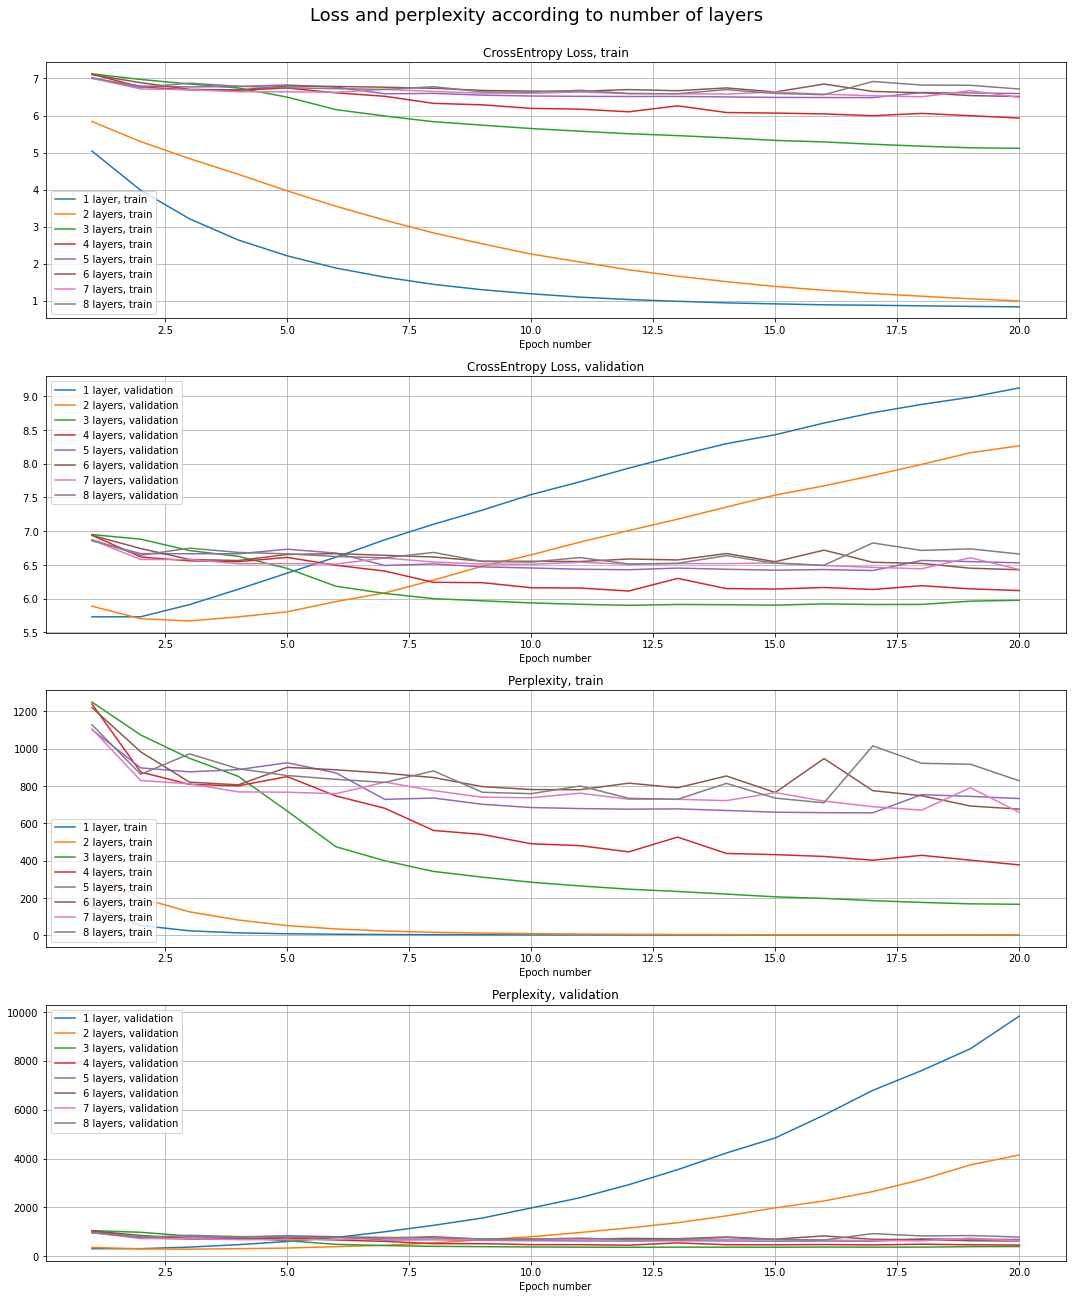

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(15, 18))
plt.suptitle('Loss and perplexity according to number of layers', y=1, fontsize=18)

epoch_nums = np.arange(20) + 1

axes[0].plot(epoch_nums, train_losses_l[0], label='1 layer, train')
axes[0].plot(epoch_nums, train_losses_l[1], label='2 layers, train')
axes[0].plot(epoch_nums, train_losses_l[2], label='3 layers, train')
axes[0].plot(epoch_nums, train_losses_l[3], label='4 layers, train')
axes[0].plot(epoch_nums, train_losses_l[4], label='5 layers, train')
axes[0].plot(epoch_nums, train_losses_l[5], label='6 layers, train')
axes[0].plot(epoch_nums, train_losses_l[6], label='7 layers, train')
axes[0].plot(epoch_nums, train_losses_l[7], label='8 layers, train')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch number')
axes[0].set_title('CrossEntropy Loss, train')

axes[1].plot(epoch_nums, val_losses_l[0], label='1 layer, validation')
axes[1].plot(epoch_nums, val_losses_l[1], label='2 layers, validation')
axes[1].plot(epoch_nums, val_losses_l[2], label='3 layers, validation')
axes[1].plot(epoch_nums, val_losses_l[3], label='4 layers, validation')
axes[1].plot(epoch_nums, val_losses_l[4], label='5 layers, validation')
axes[1].plot(epoch_nums, val_losses_l[5], label='6 layers, validation')
axes[1].plot(epoch_nums, val_losses_l[6], label='7 layers, validation')
axes[1].plot(epoch_nums, val_losses_l[7], label='8 layers, validation')


axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch number')
axes[1].set_title('CrossEntropy Loss, validation')



axes[2].plot(epoch_nums, train_ppls_l[0], label='1 layer, train')
axes[2].plot(epoch_nums, train_ppls_l[1], label='2 layers, train')
axes[2].plot(epoch_nums, train_ppls_l[2], label='3 layers, train')
axes[2].plot(epoch_nums, train_ppls_l[3], label='4 layers, train')
axes[2].plot(epoch_nums, train_ppls_l[4], label='5 layers, train')
axes[2].plot(epoch_nums, train_ppls_l[5], label='6 layers, train')
axes[2].plot(epoch_nums, train_ppls_l[6], label='7 layers, train')
axes[2].plot(epoch_nums, train_ppls_l[7], label='8 layers, train')

axes[2].legend()
axes[2].grid(True)
axes[2].set_xlabel('Epoch number')
axes[2].set_title('Perplexity, train')



axes[3].plot(epoch_nums, val_ppls_l[0], label='1 layer, validation')
axes[3].plot(epoch_nums, val_ppls_l[1], label='2 layers, validation')
axes[3].plot(epoch_nums, val_ppls_l[2], label='3 layers, validation')
axes[3].plot(epoch_nums, val_ppls_l[3], label='4 layers, validation')
axes[3].plot(epoch_nums, val_ppls_l[4], label='5 layers, validation')
axes[3].plot(epoch_nums, val_ppls_l[5], label='6 layers, validation')
axes[3].plot(epoch_nums, val_ppls_l[6], label='7 layers, validation')
axes[3].plot(epoch_nums, val_ppls_l[7], label='8 layers, validation')


axes[3].legend()
axes[3].grid(True)
axes[3].set_xlabel('Epoch number')
axes[3].set_title('Perplexity, validation')

fig.tight_layout()
plt.show()

По данным графикам можно сказать, что сети с числом слоев, большим или равным 4, не смогли обучиться в достаточной мере, потери на обучении убывают очень слабо, и их значения не сильно отличаются от потерь на валидации. Таким образом, для их обучения требуется большее число эпох или, возможно, другие параметры оптимизатора. У 3-слойной модели потери на обучении убывают значительно лучше, однако на валидации они меняются не сильно. Перплексия на обучающей выборке остается достаточно большой, что также свидетельствует о недостаточном обучении сети. Однако при этом достигается наименьшее значение перплексии на валидации среди всех остальных вариантов. Для 1- и 2-слойных сетей потери на обучении убывают лучше всего, однако на валидации они начинают достаточно сильно возрастать уже после 5 эпохи, и характер роста напоминает линейный. Таким образом, сети с 1 и 2 слоями все же смогли обучиться и даже переобучиться за 20 эпох, для 1-слойной модели переобучение сильнее. Перплексия на обучении значительно меньше, чем у остальных сетей. Стоит отметить, что подобные результаты получались и при обучении с 30 эпохами.

В целом по данным графикам можно сделать вывод о том, что 1-слойная модель является слишком простой для данной задачи, а модели с более чем 4 слоями не дают желаемого прироста качества и не успевают обучиться за отведенное число эпох. Оптимальным видится число слоев LSTM от 2 до 4, что согласуется с результатами различных исследований в статьях и практическими наблюдениями и рекомендациями. С точки зрения перплексии на валидационной выборке наилучшие результаты продемонстрировала сеть с 3 слоями, потери на обучении для нее также в целом убывают неплохо. Также для этой модели не наблюдается заметного переобучения. Предварительно зафиксируем данное число слоев как оптимальное для дальнейших экспериментов. 

# Размерность скрытого представления

Теперь сравним результаты для 3 слойной модели при различных размерностях скрытого состояния при той же размерности эмбеддинга.

In [ ]:
train_losses_h = []
val_losses_h = []
train_ppls_h = []
val_ppls_h = []
hidden_dims = [16, 32, 64, 128, 256, 512]
for hidden_dim in hidden_dims:
    model = LSTMLM(embedding_dim=512, hidden_dim=hidden_dim, vocab=vocab, num_layers=3).to(device)
    loss_fn = LMCrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_losses, train_ppls, val_losses, val_ppls = train_lm(
            train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, True
        )
    train_losses_h.append(train_losses)
    train_ppls_h.append(train_ppls)
    val_losses_h.append(val_losses)
    val_ppls_h.append(val_ppls)

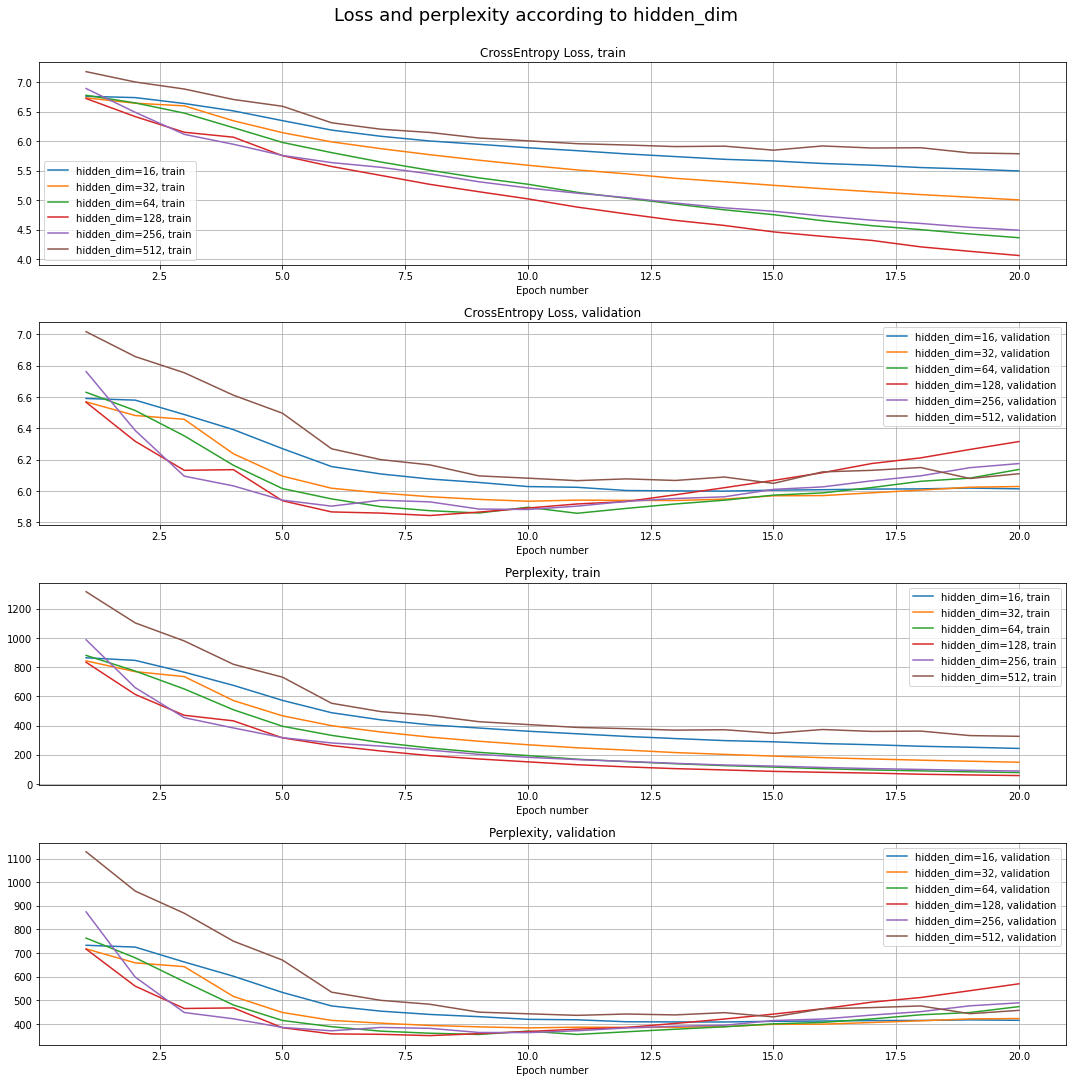

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(15, 15))
plt.suptitle('Loss and perplexity according to hidden_dim', y=1, fontsize=18)
epoch_nums = np.arange(20) + 1

axes[0].plot(epoch_nums, train_losses_h[0], label='hidden_dim=16, train')
axes[0].plot(epoch_nums, train_losses_h[1], label='hidden_dim=32, train')
axes[0].plot(epoch_nums, train_losses_h[2], label='hidden_dim=64, train')
axes[0].plot(epoch_nums, train_losses_h[3], label='hidden_dim=128, train')
axes[0].plot(epoch_nums, train_losses_h[4], label='hidden_dim=256, train')
axes[0].plot(epoch_nums, train_losses_h[5], label='hidden_dim=512, train')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch number')
axes[0].set_title('CrossEntropy Loss, train')

axes[1].plot(epoch_nums, val_losses_h[0], label='hidden_dim=16, validation')
axes[1].plot(epoch_nums, val_losses_h[1], label='hidden_dim=32, validation')
axes[1].plot(epoch_nums, val_losses_h[2], label='hidden_dim=64, validation')
axes[1].plot(epoch_nums, val_losses_h[3], label='hidden_dim=128, validation')
axes[1].plot(epoch_nums, val_losses_h[4], label='hidden_dim=256, validation')
axes[1].plot(epoch_nums, val_losses_h[5], label='hidden_dim=512, validation')



axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch number')
axes[1].set_title('CrossEntropy Loss, validation')



axes[2].plot(epoch_nums, train_ppls_h[0], label='hidden_dim=16, train')
axes[2].plot(epoch_nums, train_ppls_h[1], label='hidden_dim=32, train')
axes[2].plot(epoch_nums, train_ppls_h[2], label='hidden_dim=64, train')
axes[2].plot(epoch_nums, train_ppls_h[3], label='hidden_dim=128, train')
axes[2].plot(epoch_nums, train_ppls_h[4], label='hidden_dim=256, train')
axes[2].plot(epoch_nums, train_ppls_h[5], label='hidden_dim=512, train')

axes[2].legend()
axes[2].grid(True)
axes[2].set_xlabel('Epoch number')
axes[2].set_title('Perplexity, train')



axes[3].plot(epoch_nums, val_ppls_h[0], label='hidden_dim=16, validation')
axes[3].plot(epoch_nums, val_ppls_h[1], label='hidden_dim=32, validation')
axes[3].plot(epoch_nums, val_ppls_h[2], label='hidden_dim=64, validation')
axes[3].plot(epoch_nums, val_ppls_h[3], label='hidden_dim=128, validation')
axes[3].plot(epoch_nums, val_ppls_h[4], label='hidden_dim=256, validation')
axes[3].plot(epoch_nums, val_ppls_h[5], label='hidden_dim=512, validation')


axes[3].legend()
axes[3].grid(True)
axes[3].set_xlabel('Epoch number')
axes[3].set_title('Perplexity, validation')

fig.tight_layout()
plt.show()

Потери на обучении для различных размерностей убывают достаточно хорошо, однако практически во всех случаях наблюдается переобучение примерно после 10 эпохи. Исключение составляют сети со скрытыми представлениями размерности 16, 32, и 512, но в случае размерности 512 сеть не успела достаточно хорошо обучиться. Оптимальным с точки зрения качества на обучении и валидации является значение 32. Однако стоит учесть, что эксперименты проводились при достаточно большой фиксированной размерности эмбеддинга 512. Для более объективной оценки требуется перебирать параметры в совокупности, что будет сделано в дальнейшем.

# Размерность эмбеддингов

Теперь рассмотрим различные значения размерности эмбеддингов слов. 

In [ ]:
train_losses_e = []
val_losses_e = []
train_ppls_e = []
val_ppls_e = []
embedding_dims = [16, 32, 64, 128, 256, 512]
for embedding_dim in embedding_dims:
    model = LSTMLM(embedding_dim=embedding_dim, hidden_dim=32, vocab=vocab, num_layers=3).to(device)
    loss_fn = LMCrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_losses, train_ppls, val_losses, val_ppls = train_lm(
            train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, True
        )
    train_losses_e.append(train_losses)
    train_ppls_e.append(train_ppls)
    val_losses_e.append(val_losses)
    val_ppls_e.append(val_ppls)

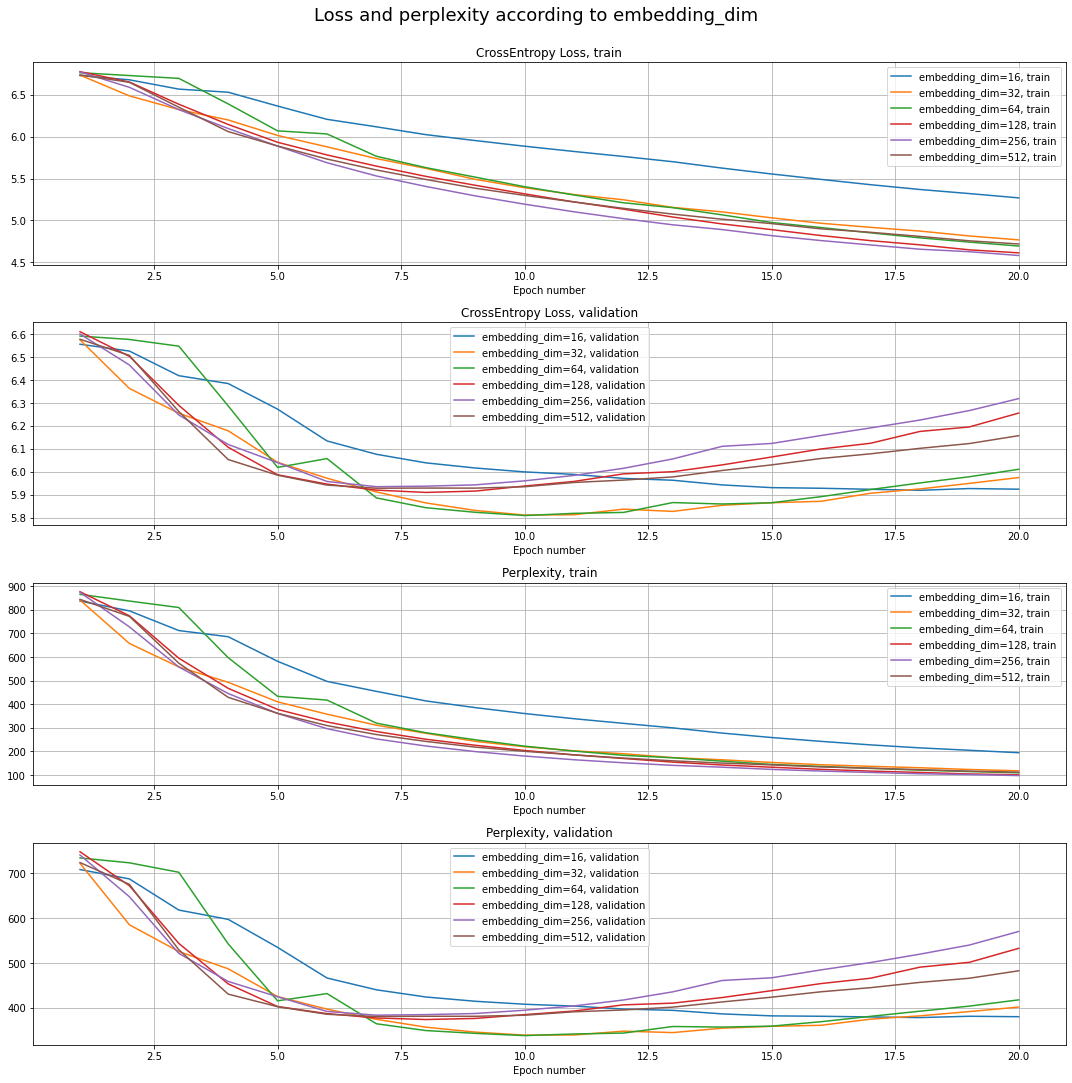

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(15, 15))
plt.suptitle('Loss and perplexity according to embedding_dim', y=1, fontsize=18)
epoch_nums = np.arange(20) + 1

axes[0].plot(epoch_nums, train_losses_e[0], label='embedding_dim=16, train')
axes[0].plot(epoch_nums, train_losses_e[1], label='embedding_dim=32, train')
axes[0].plot(epoch_nums, train_losses_e[2], label='embedding_dim=64, train')
axes[0].plot(epoch_nums, train_losses_e[3], label='embedding_dim=128, train')
axes[0].plot(epoch_nums, train_losses_e[4], label='embedding_dim=256, train')
axes[0].plot(epoch_nums, train_losses_e[5], label='embedding_dim=512, train')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch number')
axes[0].set_title('CrossEntropy Loss, train')

axes[1].plot(epoch_nums, val_losses_e[0], label='embedding_dim=16, validation')
axes[1].plot(epoch_nums, val_losses_e[1], label='embedding_dim=32, validation')
axes[1].plot(epoch_nums, val_losses_e[2], label='embedding_dim=64, validation')
axes[1].plot(epoch_nums, val_losses_e[3], label='embedding_dim=128, validation')
axes[1].plot(epoch_nums, val_losses_e[4], label='embedding_dim=256, validation')
axes[1].plot(epoch_nums, val_losses_e[5], label='embedding_dim=512, validation')



axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch number')
axes[1].set_title('CrossEntropy Loss, validation')



axes[2].plot(epoch_nums, train_ppls_e[0], label='embedding_dim=16, train')
axes[2].plot(epoch_nums, train_ppls_e[1], label='embedding_dim=32, train')
axes[2].plot(epoch_nums, train_ppls_e[2], label='embeding_dim=64, train')
axes[2].plot(epoch_nums, train_ppls_e[3], label='embedding_dim=128, train')
axes[2].plot(epoch_nums, train_ppls_e[4], label='embeding_dim=256, train')
axes[2].plot(epoch_nums, train_ppls_e[5], label='embeding_dim=512, train')

axes[2].legend()
axes[2].grid(True)
axes[2].set_xlabel('Epoch number')
axes[2].set_title('Perplexity, train')



axes[3].plot(epoch_nums, val_ppls_e[0], label='embedding_dim=16, validation')
axes[3].plot(epoch_nums, val_ppls_e[1], label='embedding_dim=32, validation')
axes[3].plot(epoch_nums, val_ppls_e[2], label='embedding_dim=64, validation')
axes[3].plot(epoch_nums, val_ppls_e[3], label='embedding_dim=128, validation')
axes[3].plot(epoch_nums, val_ppls_e[4], label='embedding_dim=256, validation')
axes[3].plot(epoch_nums, val_ppls_e[5], label='embedding_dim=512, validation')


axes[3].legend()
axes[3].grid(True)
axes[3].set_xlabel('Epoch number')
axes[3].set_title('Perplexity, validation')

fig.tight_layout()
plt.show()

На обучении потери убывают схожим образом для всех значений кроме 16, однако при этом имеется переобучение, перплексия на валидации достаточно высокая. Наилучшее качество на валидации достигается при размерности эмбеддинга, равной 16, но при этом оно близко к качеству на обучении. Потери убывают на протяжении всех эпох. Оптимальными можно назвать размерности 16 и 32 с точки зрения итогового качества.

Рассмотрим и оценим пример генерации текста моделями с выбранными значениями гиперпараметров. Рассмотрим размерности эмбеддингов, равные 16 и 32.

In [ ]:
model = LSTMLM(embedding_dim=16, hidden_dim=32, vocab=vocab, num_layers=3).to(device)
loss_fn = LMCrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_losses, train_ppls, val_losses, val_ppls = train_lm(
        train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, False
    )

Epoch: 1/20; Loss (Train/Val): 6.771/6.604; Perplexity (Train/Val): 874.521/743.964
Epoch: 2/20; Loss (Train/Val): 6.724/6.572; Perplexity (Train/Val): 834.095/720.196
Epoch: 3/20; Loss (Train/Val): 6.682/6.549; Perplexity (Train/Val): 800.463/703.925
Epoch: 4/20; Loss (Train/Val): 6.400/6.284; Perplexity (Train/Val): 603.787/540.574
Epoch: 5/20; Loss (Train/Val): 6.206/6.124; Perplexity (Train/Val): 497.391/461.415
Epoch: 6/20; Loss (Train/Val): 6.070/6.034; Perplexity (Train/Val): 433.885/421.892
Epoch: 7/20; Loss (Train/Val): 5.975/5.993; Perplexity (Train/Val): 394.654/405.195
Epoch: 8/20; Loss (Train/Val): 5.870/5.949; Perplexity (Train/Val): 355.408/387.788
Epoch: 9/20; Loss (Train/Val): 5.788/5.926; Perplexity (Train/Val): 327.427/378.784
Epoch: 10/20; Loss (Train/Val): 5.701/5.893; Perplexity (Train/Val): 300.189/366.956
Epoch: 11/20; Loss (Train/Val): 5.626/5.881; Perplexity (Train/Val): 278.414/362.512
Epoch: 12/20; Loss (Train/Val): 5.577/5.897; Perplexity (Train/Val): 265.1

Реализуем декодер с возможностью двух стратегий декодирования: жадной (генерация наиболее вероятного токена) и top-k (оставляются k наиболее вероятных токенов, и их вероятности нормируются). Жадное декодирование эквивалентно top-k с k=1. Длину получаемой последовательности также ограничим 20 токенами.

In [25]:
def decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=None):
    embedding = model.word_embeddings(start_tokens)
    hs, cs = [], []
    h = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    c = embedding.new_zeros([model.rnn.num_layers, start_tokens.shape[1], model.hidden_dim])
    for t in range(start_tokens.shape[0]):
        res, (h, c) = model.rnn(embedding[t].unsqueeze(dim=0), (h, c))
        hs.append(h)
        cs.append(c)    
    hs = torch.stack(hs, dim=1)
    cs = torch.stack(cs, dim=1)
    h = hs[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    c = cs[:, start_tokens_lens - 1, torch.arange(start_tokens_lens.shape[0])]
    predicted_tokens = []
    decoded_lens = torch.zeros_like(start_tokens_lens, dtype=torch.long)
    is_finished_decoding = torch.zeros_like(start_tokens_lens, dtype=torch.bool)
    
    while not torch.all(is_finished_decoding) and torch.max(decoded_lens) < max_generated_len:
        logits = model.output(h[-1])
        if top_k is not None:
            remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
            logits[remove] = -1e10
            next_token = torch.distributions.categorical.Categorical(logits=logits).sample()
        else:
            next_token = logits.argmax(axis=1)
            
        predicted_tokens.append(next_token)
        decoded_lens += (~is_finished_decoding)
        is_finished_decoding |= (next_token == torch.tensor(model.vocab.lookup_indices(['<eos>'])[0]))
        embedding = model.word_embeddings(next_token)
        res, (h, c) = model.rnn(embedding.unsqueeze(dim=0), (h, c))

    return torch.stack(predicted_tokens), decoded_lens

Попробуем продолжить последовательности с различными началами и генерировать текст с нуля.

In [ ]:
start_tokens = torch.tensor([
    model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'song']),
    model.vocab.lookup_indices(['<sos>', 'the', 'best', 'moment']),
    model.vocab.lookup_indices(['<sos>', 'five', 'years', 'ago']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [ ]:
model = model.cpu()
model.eval()
decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1)

Пока что рассмотрим результат жадной стратегии декодирования.

In [ ]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> the <unk> of the <unk> of the th states <eos>
<sos> my favorite song in a first season of the <unk> and <unk> , the <unk> and the <unk> and <eos>
<sos> the best moment of a <unk> of the th century was the first album , which was a <unk> of <eos>
<sos> five years ago and the <unk> of the <unk> of the th century , the first season of a <unk> <eos>


Полученный текст имеет определенную и в целом логичную структуру, похожую на реальные предложения, но в общем результат не слишком хорош. Присутствует много токенов <unk\>, генерируемые слова однообразны, есть не слишком логичные переходы между связными фрагментами предложений, есть предложения короче 20 токенов. Вероятно это произошло в силу малоразмерных представлений слов и скрытых состояний, или модель все же недостаточно обучилась. Однако довольно хорошо расставлены знаки препинания и различные артикли, предлоги и местоимения. Можно проследить некий смысл, в принципе согласующийся с началами.

Сравним результаты для эмбеддингов размерностью 32.

In [26]:
model = LSTMLM(embedding_dim=32, hidden_dim=32, vocab=vocab, num_layers=3).to(device)
loss_fn = LMCrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_losses, train_ppls, val_losses, val_ppls = train_lm(
        train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, False
    )

Epoch: 1/20; Loss (Train/Val): 6.768/6.594; Perplexity (Train/Val): 872.400/735.912
Epoch: 2/20; Loss (Train/Val): 6.738/6.581; Perplexity (Train/Val): 846.116/727.034
Epoch: 3/20; Loss (Train/Val): 6.720/6.571; Perplexity (Train/Val): 831.315/719.204
Epoch: 4/20; Loss (Train/Val): 6.651/6.511; Perplexity (Train/Val): 775.224/677.450
Epoch: 5/20; Loss (Train/Val): 6.537/6.394; Perplexity (Train/Val): 692.217/602.974
Epoch: 6/20; Loss (Train/Val): 6.305/6.199; Perplexity (Train/Val): 548.818/496.986
Epoch: 7/20; Loss (Train/Val): 6.145/6.085; Perplexity (Train/Val): 467.849/444.051
Epoch: 8/20; Loss (Train/Val): 6.025/6.020; Perplexity (Train/Val): 415.031/416.137
Epoch: 9/20; Loss (Train/Val): 6.098/6.146; Perplexity (Train/Val): 446.373/471.660
Epoch: 10/20; Loss (Train/Val): 5.793/5.910; Perplexity (Train/Val): 329.002/373.012
Epoch: 11/20; Loss (Train/Val): 5.700/5.877; Perplexity (Train/Val): 299.726/360.863
Epoch: 12/20; Loss (Train/Val): 5.672/5.918; Perplexity (Train/Val): 291.5

In [27]:
start_tokens = torch.tensor([
    model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'song']),
    model.vocab.lookup_indices(['<sos>', 'the', 'best', 'moment']),
    model.vocab.lookup_indices(['<sos>', 'five', 'years', 'ago']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [28]:
model = model.cpu()
model.eval()
decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1)

In [29]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> the first episode was a first <unk> of the <unk> <unk> and <unk> <unk> , which was a large <eos>
<sos> my favorite song was a <unk> of the <unk> , and the <unk> <unk> <unk> and <unk> <unk> <unk> <eos>
<sos> the best moment of the first episode of the first season of the <unk> , the first <unk> <unk> , <eos>
<sos> five years ago was a <unk> of the <unk> , the first <unk> <unk> and <unk> <unk> <unk> <unk> <eos>


Токенов <unk\> стало больше, появились повторения ближе к концу генерируемых последовательностей. Как отмечается в некоторых исследованиях, причиной этого может быть ориентация на максимизацию правдоподобия при генерации. Но структура предложений по прежнему соблюдена, имеются достаточно адекватные фрагменты.

Проведенный выше перебор гиперпараметров проводился при фиксированных значених некоторых из них. Для более объективного исследования проведем более полный подбор. По результатам экспериментов можно сказать, что стоит рассмотреть 2-, 3- и 4-слойные модели, т. к. 1-слойная модель слишком проста для данных текстов, а более сложные сети не смогут должным образом обучиться и дать прирост качества. Будем перебирать размерности эмбеддингов и скрытых состояний в совокупности при фиксированном числе слоев LSTM.

# Совокупный перебор параметров

Начнем с рассмотрения 2-слойной модели.

In [ ]:
embedding_dims = [16, 32, 64, 128, 256, 512]
hidden_dims = [16, 32, 64, 128, 256, 512]

train_ppls_d = {}
val_ppls_d = {}

best_val_ppl = None
best_ed = None
best_hd = None

for embedding_dim in embedding_dims:
    for hidden_dim in hidden_dims:
        model = LSTMLM(embedding_dim=embedding_dim, hidden_dim=hidden_dim, vocab=vocab, num_layers=2).to(device)
        loss_fn = LMCrossEntropyLoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            train_losses, train_ppls, val_losses, val_ppls = train_lm(
                train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, True
            )
        train_ppl = train_ppls[-1]
        val_ppl = val_ppls[-1]
        if best_val_ppl is None or val_ppl < best_val_ppl:
            best_val_ppl = val_ppl
            best_ed = embedding_dim
            best_hd = hidden_dim
        train_ppls_d[(embedding_dim, hidden_dim)] = train_ppl
        val_ppls_d[(embedding_dim, hidden_dim)] = val_ppl
        
print(f'Best val perplexity: {best_val_ppl}')
print(f'Best embedding_dim: {best_ed}')
print(f'Best hidden_dim: {best_hd}')
        
        


Best val perplexity: 371.0987505928498
Best embedding_dim: 16
Best hidden_dim: 32


Наилучшие с точки зрения качества на валидации значения размерностей достаточно небольшие, несмотря на большой размер словаря и относительную сложность текстов.

Для полноты картины выведем итоговые перплексии на обучении и валидации для всех рассмотренных комбинаций значений параметров. Т. к. их достаточно много, то изобразить наглядно на графиках динамику изменений потерь и перплексии затруднительно, поэтому выведем лишь финальные значения перплексии для каждой комбинации. В ключе словаря в паре на первой позиции указана размерность эмбеддинга, на второй - размерность скрытого состояния.

In [ ]:
train_ppls_d

{(16, 16): 212.00745111224333,
 (16, 32): 133.3168330997441,
 (16, 64): 116.18762763902654,
 (16, 128): 44.250883977957905,
 (16, 256): 58.182000413977185,
 (16, 512): 19.014827012274754,
 (32, 16): 179.20554561390105,
 (32, 32): 104.22927528412296,
 (32, 64): 67.17029096112229,
 (32, 128): 33.51643909065023,
 (32, 256): 50.377837310153105,
 (32, 512): 13.878542691080991,
 (64, 16): 151.208004774798,
 (64, 32): 101.06981806926927,
 (64, 64): 61.63688309673335,
 (64, 128): 35.478798204440956,
 (64, 256): 28.744248318612513,
 (64, 512): 9.606840451369179,
 (128, 16): 152.1540797989175,
 (128, 32): 82.59964938748527,
 (128, 64): 44.5479248875206,
 (128, 128): 43.275359656870904,
 (128, 256): 30.060239589814362,
 (128, 512): 8.554044393496437,
 (256, 16): 171.16246224288983,
 (256, 32): 76.99565486301024,
 (256, 64): 51.942690846250024,
 (256, 128): 36.22345660365207,
 (256, 256): 30.84478427122869,
 (256, 512): 3.6655240920550516,
 (512, 16): 175.63524575853558,
 (512, 32): 92.91163863822

Перплексия на обучении для лучших на валидации параметров довольно высокая, но в целом сеть смогла нормально обучиться. При других значениях параметров потери на обучении меньше, но на валидации они больше.

In [ ]:
val_ppls_d

{(16, 16): 377.55965111221496,
 (16, 32): 371.0987505928498,
 (16, 64): 387.03393894587936,
 (16, 128): 494.7563324788952,
 (16, 256): 484.42834989668387,
 (16, 512): 710.4321389092187,
 (32, 16): 404.3270598265653,
 (32, 32): 394.9057980846742,
 (32, 64): 421.1075723279345,
 (32, 128): 554.8878491948279,
 (32, 256): 460.5635032352936,
 (32, 512): 870.1127142594934,
 (64, 16): 397.38719591425377,
 (64, 32): 438.83128011342717,
 (64, 64): 448.0540351366291,
 (64, 128): 564.8143038875553,
 (64, 256): 610.208799513432,
 (64, 512): 1008.7627780190704,
 (128, 16): 456.06538542912926,
 (128, 32): 488.3932509923531,
 (128, 64): 531.288826622221,
 (128, 128): 517.7441558241702,
 (128, 256): 602.6788822957836,
 (128, 512): 1156.3618283440233,
 (256, 16): 429.56683638795664,
 (256, 32): 513.2869627095062,
 (256, 64): 493.8602294679437,
 (256, 128): 548.167345764986,
 (256, 256): 584.0546522900879,
 (256, 512): 2491.083112780889,
 (512, 16): 421.665996054394,
 (512, 32): 450.9278347742334,
 (512,

При других размерностях перплексия на валидационной выборке значительно выше. С ростом размерностей эмбеддингов и скрытого представления эффект переобучения становится сильнее.

Рассмотрим результат генерации с найденными параметрами.

In [ ]:
model = LSTMLM(embedding_dim=16, hidden_dim=32, vocab=vocab, num_layers=2).to(device)
loss_fn = LMCrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_losses, train_ppls, val_losses, val_ppls = train_lm(
        train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, False
    )

Epoch: 1/20; Loss (Train/Val): 6.778/6.618; Perplexity (Train/Val): 880.919/753.695
Epoch: 2/20; Loss (Train/Val): 6.635/6.484; Perplexity (Train/Val): 763.154/659.517
Epoch: 3/20; Loss (Train/Val): 6.357/6.261; Perplexity (Train/Val): 578.373/528.681
Epoch: 4/20; Loss (Train/Val): 6.151/6.111; Perplexity (Train/Val): 470.631/454.996
Epoch: 5/20; Loss (Train/Val): 5.964/5.982; Perplexity (Train/Val): 390.421/400.661
Epoch: 6/20; Loss (Train/Val): 5.821/5.892; Perplexity (Train/Val): 338.289/366.303
Epoch: 7/20; Loss (Train/Val): 5.711/5.848; Perplexity (Train/Val): 303.312/350.445
Epoch: 8/20; Loss (Train/Val): 5.615/5.821; Perplexity (Train/Val): 275.390/341.520
Epoch: 9/20; Loss (Train/Val): 5.538/5.812; Perplexity (Train/Val): 255.017/338.564
Epoch: 10/20; Loss (Train/Val): 5.455/5.793; Perplexity (Train/Val): 234.681/332.227
Epoch: 11/20; Loss (Train/Val): 5.381/5.781; Perplexity (Train/Val): 217.885/328.454
Epoch: 12/20; Loss (Train/Val): 5.314/5.787; Perplexity (Train/Val): 203.8

In [ ]:
start_tokens = torch.tensor([
    model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'song']),
    model.vocab.lookup_indices(['<sos>', 'the', 'best', 'moment']),
    model.vocab.lookup_indices(['<sos>', 'five', 'years', 'ago']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [ ]:
model = model.cpu()
model.eval()
decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1)

In [ ]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> the first part of the first time to the th century , the <unk> of the <unk> , and the
<sos> my favorite song is a large wave of the <unk> of the <unk> , and the <unk> of the <unk> <eos>
<sos> the best moment of the <unk> of the <unk> , the <unk> of the <unk> <unk> <unk> <unk> , and <eos>
<sos> five years ago was the first episode of the season , the first part of the first season of the <eos>


Полученный текст немного лучше, чем полученный ранее для 3-слойной сети, имеет все те же преимущества и недостатки. Слова не слишком разнообразны, есть повторы, присутствуют и вполне неплохие фрагменты.

Рассмотрим 3-слойную сеть.

In [ ]:
embedding_dims = [16, 32, 64, 128, 256, 512]
hidden_dims = [16, 32, 64, 128, 256, 512]

train_ppls_d = {}
val_ppls_d = {}

best_val_ppl = None
best_ed = None
best_hd = None

for embedding_dim in embedding_dims:
    for hidden_dim in hidden_dims:
        model = LSTMLM(embedding_dim=embedding_dim, hidden_dim=hidden_dim, vocab=vocab, num_layers=3).to(device)
        loss_fn = LMCrossEntropyLoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            train_losses, train_ppls, val_losses, val_ppls = train_lm(
                train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, True
            )
        train_ppl = train_ppls[-1]
        val_ppl = val_ppls[-1]
        if best_val_ppl is None or val_ppl < best_val_ppl:
            best_val_ppl = val_ppl
            best_ed = embedding_dim
            best_hd = hidden_dim
        train_ppls_d[(embedding_dim, hidden_dim)] = train_ppl
        val_ppls_d[(embedding_dim, hidden_dim)] = val_ppl
        
print(f'Best val perplexity: {best_val_ppl}')
print(f'Best embedding_dim: {best_ed}')
print(f'Best hidden_dim: {best_hd}')
        
        


Best val perplexity: 387.99216411589356
Best embedding_dim: 16
Best hidden_dim: 64


Лучшая на валидации размерность эмбеддинга совпадает с результатами для 2-слойной сети, но размерность скрытого представления вдвое больше. В целом они также остаются сравнительно небольшими.

In [ ]:
train_ppls_d

{(16, 16): 321.4574536710322,
 (16, 32): 210.90726812318377,
 (16, 64): 139.10458850763055,
 (16, 128): 109.8414591227305,
 (16, 256): 85.40261999475098,
 (16, 512): 129.66522568117838,
 (32, 16): 275.4711771011431,
 (32, 32): 166.93197326092871,
 (32, 64): 121.58954224523278,
 (32, 128): 92.93666694467912,
 (32, 256): 76.34605589476621,
 (32, 512): 313.8863674318177,
 (64, 16): 182.18410072858742,
 (64, 32): 107.60400672623628,
 (64, 64): 85.64504158281875,
 (64, 128): 102.23770006199435,
 (64, 256): 111.1954143449511,
 (64, 512): 569.1146477584382,
 (128, 16): 344.3910808541534,
 (128, 32): 91.64256569352996,
 (128, 64): 112.08613172877476,
 (128, 128): 94.31676860864977,
 (128, 256): 152.4202313434823,
 (128, 512): 973.2317429584198,
 (256, 16): 261.0346758048473,
 (256, 32): 131.24665033015197,
 (256, 64): 62.52897754009332,
 (256, 128): 64.1415783330918,
 (256, 256): 127.1408303535137,
 (256, 512): 781.7239274266229,
 (512, 16): 425.95512603958156,
 (512, 32): 104.26530269765104,


Перплексия на обучении с найденными параметрами меньше, чем в большинстве других случаев. Но в целом можно сказать, что 3-слойная сеть хуже обучается при том же числе эпох.

In [ ]:
val_ppls_d

{(16, 16): 419.750638367922,
 (16, 32): 413.36948099679813,
 (16, 64): 387.99216411589356,
 (16, 128): 404.8709195792078,
 (16, 256): 436.2986955501411,
 (16, 512): 390.10960322262474,
 (32, 16): 429.47417557276566,
 (32, 32): 397.21985955994614,
 (32, 64): 437.3003257325623,
 (32, 128): 426.51461036651875,
 (32, 256): 429.9075894153686,
 (32, 512): 422.8775614293063,
 (64, 16): 421.529188315453,
 (64, 32): 467.62438027308417,
 (64, 64): 483.16352578589294,
 (64, 128): 446.58043340595844,
 (64, 256): 425.46821224309093,
 (64, 512): 582.2797519975616,
 (128, 16): 438.38176227997315,
 (128, 32): 513.4589962250596,
 (128, 64): 445.3802180373105,
 (128, 128): 492.33190847683085,
 (128, 256): 402.59730353636843,
 (128, 512): 886.3137852376925,
 (256, 16): 459.1874401142243,
 (256, 32): 406.9770882995529,
 (256, 64): 600.9217741799004,
 (256, 128): 559.7831077038165,
 (256, 256): 413.0987739265991,
 (256, 512): 735.9272639196033,
 (512, 16): 447.9580479888158,
 (512, 32): 475.35671457145435,

Качество на валидации в основном стало ближе к качеству на обучении, в некоторых случаях заметен эффект недообучения. Также нет сильного переобучения для высоких размерностей.

Рассмотрим генерируемый моделью с лучшими на валидации параметрами текст.

In [ ]:
model = LSTMLM(embedding_dim=16, hidden_dim=64, vocab=vocab, num_layers=3).to(device)
loss_fn = LMCrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_losses, train_ppls, val_losses, val_ppls = train_lm(
        train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, False
    )

Epoch: 1/20; Loss (Train/Val): 6.684/6.522; Perplexity (Train/Val): 801.846/685.386
Epoch: 2/20; Loss (Train/Val): 6.462/6.346; Perplexity (Train/Val): 642.033/575.326
Epoch: 3/20; Loss (Train/Val): 6.230/6.171; Perplexity (Train/Val): 509.641/483.708
Epoch: 4/20; Loss (Train/Val): 6.120/6.125; Perplexity (Train/Val): 456.383/462.618
Epoch: 5/20; Loss (Train/Val): 5.934/6.006; Perplexity (Train/Val): 378.973/410.715
Epoch: 6/20; Loss (Train/Val): 5.826/5.966; Perplexity (Train/Val): 340.190/395.064
Epoch: 7/20; Loss (Train/Val): 5.752/5.956; Perplexity (Train/Val): 315.643/391.313
Epoch: 8/20; Loss (Train/Val): 5.643/5.912; Perplexity (Train/Val): 282.900/375.175
Epoch: 9/20; Loss (Train/Val): 5.560/5.897; Perplexity (Train/Val): 260.704/369.215
Epoch: 10/20; Loss (Train/Val): 5.482/5.881; Perplexity (Train/Val): 241.046/363.730
Epoch: 11/20; Loss (Train/Val): 5.402/5.872; Perplexity (Train/Val): 222.561/360.735
Epoch: 12/20; Loss (Train/Val): 5.333/5.873; Perplexity (Train/Val): 207.5

In [ ]:
start_tokens = torch.tensor([
    model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'song']),
    model.vocab.lookup_indices(['<sos>', 'the', 'best', 'moment']),
    model.vocab.lookup_indices(['<sos>', 'five', 'years', 'ago']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [ ]:
model = model.cpu()
model.eval()
decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1)

In [ ]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> in the early season of the th century , the th <unk> , and <unk> <unk> , and <unk> <unk>
<sos> my favorite song the largest and <unk> of the <unk> , and <unk> , who was not a <unk> , <eos>
<sos> the best moment of the th century was <unk> in the <unk> , and as the most <unk> . the <eos>
<sos> five years ago that the <unk> was a first episode of a <unk> of . the <unk> and the <eos>


Полученные последовательности не сильно отличаются от результатов 2-слойной сети, даже стали немного проще.

Проведем подбор параметров для 4-слойной сети.

In [ ]:
embedding_dims = [16, 32, 64, 128, 256, 512]
hidden_dims = [16, 32, 64, 128, 256, 512]

train_ppls_d = {}
val_ppls_d = {}

best_val_ppl = None
best_ed = None
best_hd = None

for embedding_dim in embedding_dims:
    for hidden_dim in hidden_dims:
        model = LSTMLM(embedding_dim=embedding_dim, hidden_dim=hidden_dim, vocab=vocab, num_layers=4).to(device)
        loss_fn = LMCrossEntropyLoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            train_losses, train_ppls, val_losses, val_ppls = train_lm(
                train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, True
            )
        train_ppl = train_ppls[-1]
        val_ppl = val_ppls[-1]
        if best_val_ppl is None or val_ppl < best_val_ppl:
            best_val_ppl = val_ppl
            best_ed = embedding_dim
            best_hd = hidden_dim
        train_ppls_d[(embedding_dim, hidden_dim)] = train_ppl
        val_ppls_d[(embedding_dim, hidden_dim)] = val_ppl
        
print(f'Best val perplexity: {best_val_ppl}')
print(f'Best embedding_dim: {best_ed}')
print(f'Best hidden_dim: {best_hd}')
        
        


Best val perplexity: 397.6705557629408
Best embedding_dim: 16
Best hidden_dim: 128


Лучшая размерность эмбеддинга осталось той же, размерность скрытого представления снова возрасла вдвое.

In [ ]:
train_ppls_d

{(16, 16): 404.3475075362002,
 (16, 32): 589.448953660254,
 (16, 64): 265.6745688403488,
 (16, 128): 202.80319627626082,
 (16, 256): 290.24160091349745,
 (16, 512): 636.2142133712409,
 (32, 16): 297.1307187070049,
 (32, 32): 225.71325608565095,
 (32, 64): 172.82278469972198,
 (32, 128): 583.5918304213044,
 (32, 256): 637.5669593050361,
 (32, 512): 694.3281806509449,
 (64, 16): 272.9964538916378,
 (64, 32): 149.05829471635,
 (64, 64): 675.3314836224758,
 (64, 128): 157.19896018020404,
 (64, 256): 618.5359437936103,
 (64, 512): 396.12635117253154,
 (128, 16): 658.9239342761343,
 (128, 32): 215.10187277613372,
 (128, 64): 119.50178984822053,
 (128, 128): 178.72533778009495,
 (128, 256): 624.1393987237311,
 (128, 512): 390.96847991456826,
 (256, 16): 345.6442036284538,
 (256, 32): 172.38262511630037,
 (256, 64): 126.9176437903754,
 (256, 128): 157.83946578345086,
 (256, 256): 115.50326115177526,
 (256, 512): 649.7056507113207,
 (512, 16): 402.55279874956074,
 (512, 32): 319.71775466281093,

Значения перплексии на обучении для разных комбинаций стали еще больше, 4-слойной сети недостаточно 20 эпох для качественного обучения.

In [ ]:
val_ppls_d

{(16, 16): 439.77109371552336,
 (16, 32): 609.4884352461468,
 (16, 64): 446.1625427158067,
 (16, 128): 397.6705557629408,
 (16, 256): 403.3961433735877,
 (16, 512): 616.1960288344803,
 (32, 16): 445.98643460458374,
 (32, 32): 415.7445697155459,
 (32, 64): 431.50589210451307,
 (32, 128): 616.6105421744976,
 (32, 256): 629.3561170102552,
 (32, 512): 690.4188939162201,
 (64, 16): 425.9428853293897,
 (64, 32): 532.9900045840409,
 (64, 64): 671.5210433888957,
 (64, 128): 441.91836213990047,
 (64, 256): 607.0533764543674,
 (64, 512): 503.4607813535021,
 (128, 16): 588.0040069890764,
 (128, 32): 417.4902578929028,
 (128, 64): 490.5004994179119,
 (128, 128): 422.4274897433117,
 (128, 256): 608.7662116884867,
 (128, 512): 471.4041202077166,
 (256, 16): 435.1263452798918,
 (256, 32): 435.99937520420514,
 (256, 64): 433.8176386454295,
 (256, 128): 515.0280700780693,
 (256, 256): 419.02978222567845,
 (256, 512): 606.6266836258117,
 (512, 16): 447.8120325571563,
 (512, 32): 468.4890613147196,
 (512

Качество на валидации стало еще более однородным и еще более близким к перплексии на обучении, что свидетельствует о недообучении во многих случаях.

Оценим получаемый с найденными параметрами текст.

In [ ]:
model = LSTMLM(embedding_dim=16, hidden_dim=128, vocab=vocab, num_layers=4).to(device)
loss_fn = LMCrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_losses, train_ppls, val_losses, val_ppls = train_lm(
        train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, False
    )

Epoch: 1/20; Loss (Train/Val): 6.777/6.622; Perplexity (Train/Val): 879.678/757.607
Epoch: 2/20; Loss (Train/Val): 6.597/6.483; Perplexity (Train/Val): 735.145/659.078
Epoch: 3/20; Loss (Train/Val): 6.566/6.457; Perplexity (Train/Val): 712.479/642.467
Epoch: 4/20; Loss (Train/Val): 6.505/6.420; Perplexity (Train/Val): 670.082/619.500
Epoch: 5/20; Loss (Train/Val): 6.483/6.409; Perplexity (Train/Val): 655.567/612.930
Epoch: 6/20; Loss (Train/Val): 6.396/6.352; Perplexity (Train/Val): 600.958/578.991
Epoch: 7/20; Loss (Train/Val): 6.075/6.092; Perplexity (Train/Val): 436.424/447.352
Epoch: 8/20; Loss (Train/Val): 5.909/6.018; Perplexity (Train/Val): 369.538/415.772
Epoch: 9/20; Loss (Train/Val): 5.761/5.947; Perplexity (Train/Val): 318.717/386.968
Epoch: 10/20; Loss (Train/Val): 5.647/5.931; Perplexity (Train/Val): 284.232/381.076
Epoch: 11/20; Loss (Train/Val): 5.527/5.903; Perplexity (Train/Val): 252.034/371.158
Epoch: 12/20; Loss (Train/Val): 5.454/5.893; Perplexity (Train/Val): 234.3

In [ ]:
start_tokens = torch.tensor([
    model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'song']),
    model.vocab.lookup_indices(['<sos>', 'the', 'best', 'moment']),
    model.vocab.lookup_indices(['<sos>', 'five', 'years', 'ago']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [ ]:
model = model.cpu()
model.eval()
decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1)

In [ ]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> the first version of the <unk> <unk> is a <unk> of the <unk> of the th century , and the
<sos> my favorite song is a <unk> of the <unk> of the <unk> of the united states . he was a <eos>
<sos> the best moment of the <unk> is a <unk> of the <unk> of the th century , and the <eos>
<sos> five years ago was a <unk> of the <unk> of the <unk> of the <unk> of the united states . <eos>


Результат схож с предыдущими, предложения также однотипны и имеют те же недостатки. Таким образом, для многослойной сети необходимо большее число эпох обучения или иные параметры оптимизатора, и она не дает желаемого повышения качества итогового текста.

В общем можно сказать, что при некоторых значениях гиперпараметров модели смогли относительно неплохо обучиться, но недостаточно хорошо. Во многих случаях наблюдалось недообучение, особенно с ростом числа слоев и размерностей векторов эмбеддингов и скрытых состояний. 2-слойная модель в целом лучше смогла обучиться и даже переобучиться, особенно при больших размерностях представлений и состояния. Для всех вариантов числа слоев найденный размер эмбеддинга равен 16, что кажется небольшим при объеме и специфике данных текстов. Причиной этому могло стать наличие общеупотребительной лексики, т. к. статьи в основном имеют справочный и описательный характер, а также на это могло повлиять сохранение стоп-слов и знаков препинаний. Оптимальная размерность скрытого состояния во всех случаях была больше размерности эмбеддинга, причем с ростом числа слоев LSTM она увеличивалась вдвое. Можно предположить, что на это повлияло то, что в рассмотренных текстах большое значение имеет контекст и иная специфика, и для их учета размерности представлений слов недостаточно. В целом данная гипотеза является вполне логичной и соответствующей данным. 

Оптимальной конфигурацией с точки зрения качества на обучении и валидации можно назвать модель с 2 слоями, размерностью представлений слов, равной 16, и скрытым состоянием размерностью 32. Однако в проведенных экспериментах итоговое качество было не достаточно высоким, а большие модели не успевали должным образом обучаться. Вероятно, для получения более объективных и исчерпывающих результатов можно увеличить число эпох обучения, рассмотерть другие способы и параметры обучения сети, размер батча и длину генерируемых поледовательностей, ограничить размер словаря и т. д. Также стоит учитывать зависимость от данных и остальных факторов.

# Применение dropout-регуляризации

Исследуем влияние dropout-регуляризации на качество генерируемого текста. Будем испоьзовать dropout-слой после выходов каждого слоя LSTM за исключением последнего. Для этого модифицируем использованные ранее функции реализации сети. 

In [30]:
class LSTMClassifierDO(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_size, vocab, rec_layer=torch.nn.LSTM, dropout=None, **kwargs):
        super().__init__()
        self.dropout = dropout
        self.vocab = vocab
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        self.word_embeddings = torch.nn.Embedding(num_embeddings=len(vocab), embedding_dim=embedding_dim, padding_idx=vocab.lookup_indices(['<pad>'])[0])
        if dropout is not None:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, dropout=self.dropout, **kwargs)
        else:
            self.rnn = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        self.output = torch.nn.Linear(hidden_dim, output_size)
    
    def forward(self, tokens, tokens_lens):
        res = self.word_embeddings(tokens)
        res = self.rnn(res)[0]
        res = res[tokens_lens - 1, torch.arange(len(tokens_lens))]
        res = self.output(res)
        return res

In [31]:
class LSTMLMDO(LSTMClassifierDO):
    def __init__(self, embedding_dim, hidden_dim, vocab, dropout=0.5, num_layers=1):
        super().__init__(
            embedding_dim=embedding_dim, hidden_dim=hidden_dim, output_size=len(vocab), vocab=vocab,
            rec_layer=torch.nn.LSTM, dropout=dropout, num_layers=num_layers
        )
    
    def forward(self, tokens, tokens_lens):
        embeddings = self.word_embeddings(tokens)
        embeddings = self.rnn(embeddings)[0]
        embeddings = self.output(embeddings)
        return embeddings

Сравним сеть с найденными ранее оптимальными параметрами без регуляризации и с вероятностями dropout, выбранными с шагом 0.1.

In [ ]:
train_losses_do = []
val_losses_do = []
train_ppls_do = []
val_ppls_do = []
dropout_vals = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.6, 0.7, 0.8, 0.9]
for dropout_val in dropout_vals:
    model = LSTMLMDO(embedding_dim=16, hidden_dim=32, vocab=vocab, dropout=dropout_val, num_layers=2).to(device)
    loss_fn = LMCrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        train_losses, train_ppls, val_losses, val_ppls = train_lm(
            train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, True
        )
    train_losses_do.append(train_losses)
    train_ppls_do.append(train_ppls)
    val_losses_do.append(val_losses)
    val_ppls_do.append(val_ppls)

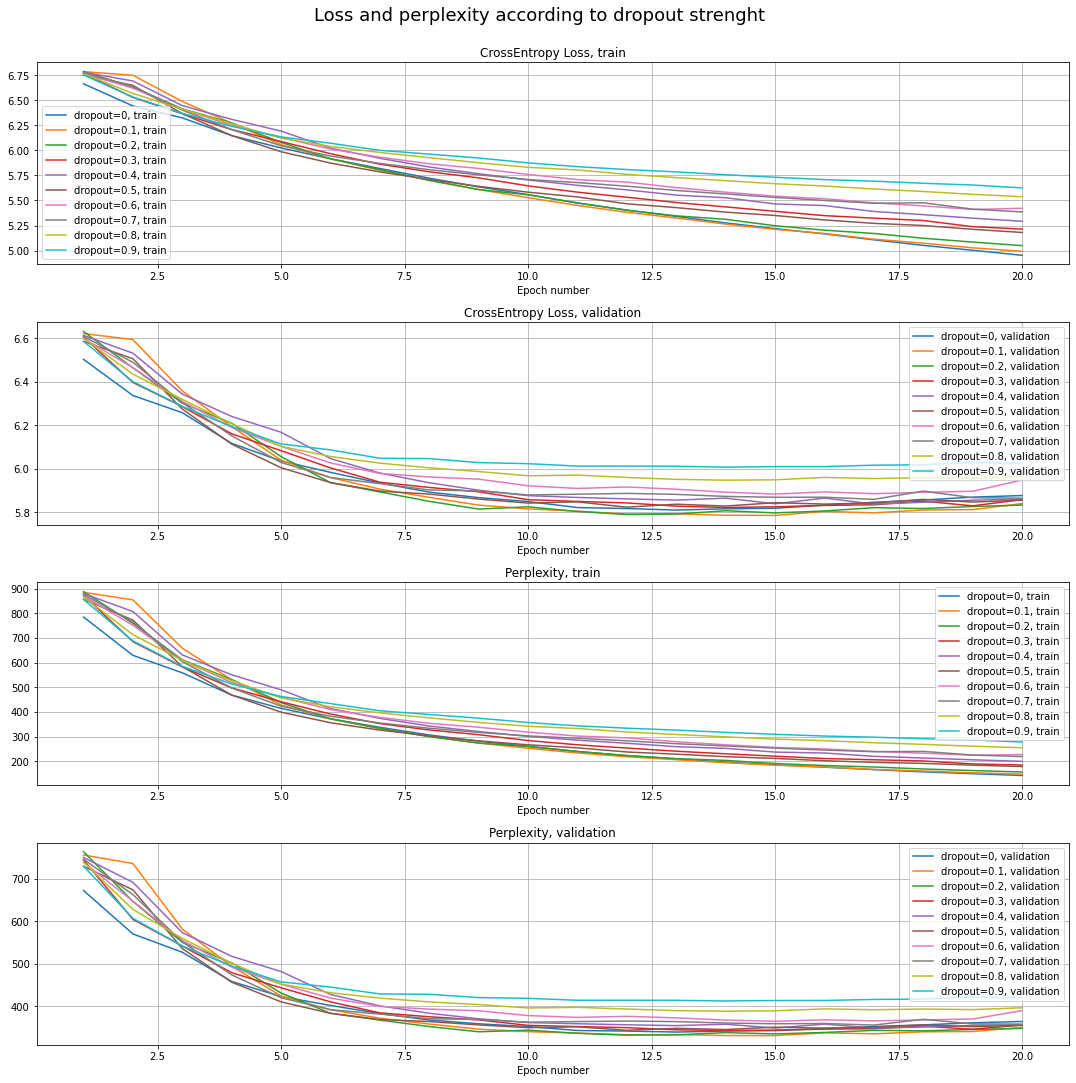

In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(15, 15))
plt.suptitle('Loss and perplexity according to dropout strenght', y=1, fontsize=18)
epoch_nums = np.arange(20) + 1

axes[0].plot(epoch_nums, train_losses_do[0], label='dropout=0, train')
axes[0].plot(epoch_nums, train_losses_do[1], label='dropout=0.1, train')
axes[0].plot(epoch_nums, train_losses_do[2], label='dropout=0.2, train')
axes[0].plot(epoch_nums, train_losses_do[3], label='dropout=0.3, train')
axes[0].plot(epoch_nums, train_losses_do[4], label='dropout=0.4, train')
axes[0].plot(epoch_nums, train_losses_do[5], label='dropout=0.5, train')
axes[0].plot(epoch_nums, train_losses_do[6], label='dropout=0.6, train')
axes[0].plot(epoch_nums, train_losses_do[7], label='dropout=0.7, train')
axes[0].plot(epoch_nums, train_losses_do[8], label='dropout=0.8, train')
axes[0].plot(epoch_nums, train_losses_do[9], label='dropout=0.9, train')

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch number')
axes[0].set_title('CrossEntropy Loss, train')

axes[1].plot(epoch_nums, val_losses_do[0], label='dropout=0, validation')
axes[1].plot(epoch_nums, val_losses_do[1], label='dropout=0.1, validation')
axes[1].plot(epoch_nums, val_losses_do[2], label='dropout=0.2, validation')
axes[1].plot(epoch_nums, val_losses_do[3], label='dropout=0.3, validation')
axes[1].plot(epoch_nums, val_losses_do[4], label='dropout=0.4, validation')
axes[1].plot(epoch_nums, val_losses_do[5], label='dropout=0.5, validation')
axes[1].plot(epoch_nums, val_losses_do[6], label='dropout=0.6, validation')
axes[1].plot(epoch_nums, val_losses_do[7], label='dropout=0.7, validation')
axes[1].plot(epoch_nums, val_losses_do[8], label='dropout=0.8, validation')
axes[1].plot(epoch_nums, val_losses_do[9], label='dropout=0.9, validation')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch number')
axes[1].set_title('CrossEntropy Loss, validation')



axes[2].plot(epoch_nums, train_ppls_do[0], label='dropout=0, train')
axes[2].plot(epoch_nums, train_ppls_do[1], label='dropout=0.1, train')
axes[2].plot(epoch_nums, train_ppls_do[2], label='dropout=0.2, train')
axes[2].plot(epoch_nums, train_ppls_do[3], label='dropout=0.3, train')
axes[2].plot(epoch_nums, train_ppls_do[4], label='dropout=0.4, train')
axes[2].plot(epoch_nums, train_ppls_do[5], label='dropout=0.5, train')
axes[2].plot(epoch_nums, train_ppls_do[6], label='dropout=0.6, train')
axes[2].plot(epoch_nums, train_ppls_do[7], label='dropout=0.7, train')
axes[2].plot(epoch_nums, train_ppls_do[8], label='dropout=0.8, train')
axes[2].plot(epoch_nums, train_ppls_do[9], label='dropout=0.9, train')

axes[2].legend()
axes[2].grid(True)
axes[2].set_xlabel('Epoch number')
axes[2].set_title('Perplexity, train')



axes[3].plot(epoch_nums, val_ppls_do[0], label='dropout=0, validation')
axes[3].plot(epoch_nums, val_ppls_do[1], label='dropout=0.1, validation')
axes[3].plot(epoch_nums, val_ppls_do[2], label='dropout=0.2, validation')
axes[3].plot(epoch_nums, val_ppls_do[3], label='dropout=0.3, validation')
axes[3].plot(epoch_nums, val_ppls_do[4], label='dropout=0.4, validation')
axes[3].plot(epoch_nums, val_ppls_do[5], label='dropout=0.5, validation')
axes[3].plot(epoch_nums, val_ppls_do[6], label='dropout=0.6, validation')
axes[3].plot(epoch_nums, val_ppls_do[7], label='dropout=0.7, validation')
axes[3].plot(epoch_nums, val_ppls_do[8], label='dropout=0.8, validation')
axes[3].plot(epoch_nums, val_ppls_do[9], label='dropout=0.9, validation')


axes[3].legend()
axes[3].grid(True)
axes[3].set_xlabel('Epoch number')
axes[3].set_title('Perplexity, validation')

fig.tight_layout()
plt.show()

Использование dropout действительно может повлиять на качество генерации, однако при слишком больших значениях вероятности итоговая перплексия становится хуже, чем без регуляризации. Но в целом различия в значениях потерь и перплексии небольшие, графики идут близко друг к другу и почти параллельно. Таким образом, влияние dropout-регуляризации на качество генерируемого текста можно назвать слабым. Наилучшие результаты как на обучении, так и на валидации дало использование dropout с веротяностью 0.2.

Проанализируем получаемый с найденными параметрами текст.

In [ ]:
model = LSTMLMDO(embedding_dim=16, hidden_dim=32, vocab=vocab, dropout=0.2, num_layers=2).to(device)
loss_fn = LMCrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_losses, train_ppls, val_losses, val_ppls = train_lm(
        train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, False
    )

Epoch: 1/20; Loss (Train/Val): 6.720/6.554; Perplexity (Train/Val): 831.461/707.830
Epoch: 2/20; Loss (Train/Val): 6.463/6.350; Perplexity (Train/Val): 642.992/577.398
Epoch: 3/20; Loss (Train/Val): 6.296/6.225; Perplexity (Train/Val): 543.962/509.892
Epoch: 4/20; Loss (Train/Val): 6.127/6.091; Perplexity (Train/Val): 459.581/446.201
Epoch: 5/20; Loss (Train/Val): 5.991/6.010; Perplexity (Train/Val): 401.200/412.578
Epoch: 6/20; Loss (Train/Val): 5.882/5.938; Perplexity (Train/Val): 359.912/383.896
Epoch: 7/20; Loss (Train/Val): 5.795/5.892; Perplexity (Train/Val): 329.896/366.922
Epoch: 8/20; Loss (Train/Val): 5.721/5.872; Perplexity (Train/Val): 306.135/359.918
Epoch: 9/20; Loss (Train/Val): 5.645/5.838; Perplexity (Train/Val): 283.740/347.665
Epoch: 10/20; Loss (Train/Val): 5.576/5.824; Perplexity (Train/Val): 264.991/343.011
Epoch: 11/20; Loss (Train/Val): 5.514/5.810; Perplexity (Train/Val): 248.847/338.215
Epoch: 12/20; Loss (Train/Val): 5.465/5.804; Perplexity (Train/Val): 236.9

In [ ]:
start_tokens = torch.tensor([
    model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'song']),
    model.vocab.lookup_indices(['<sos>', 'the', 'best', 'moment']),
    model.vocab.lookup_indices(['<sos>', 'five', 'years', 'ago']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [ ]:
model = model.cpu()
model.eval()
decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1)

In [ ]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> the first wave was a first <unk> of the <unk> of the <unk> of the <unk> of the <unk> of
<sos> my favorite song the first <unk> of the <unk> <unk> , and is a <unk> of the <unk> of the <eos>
<sos> the best moment was a first <unk> of the <unk> of the <unk> of the <unk> of the <unk> of <eos>
<sos> five years ago was a first <unk> of the <unk> of the <unk> of the <unk> <unk> , and the <eos>


Использование регуляризации действительно почти не повлияло на получаемый текст, он во многом схож с полученными ранее последовательностями.

# Стратегии докодирования

Сраним две стратегии декодирования, жадное декодирование и сэмплирование top-k. Переберем параметр k от 1 до 20 (по длине генерируемых последовательностей), сравним получаемые тексты.

Рассмотрим модель с найденными ранее оптимальными параметрами.

In [ ]:
k_values = np.arange(1, 21, dtype=int)

for k in k_values:
    print(f'k={k}:')
    decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=k)
    for text_idx in range(start_tokens.shape[1]):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words))
    print()

k=1:
<sos> the first wave was a first <unk> of the <unk> of the <unk> of the <unk> of the <unk> of
<sos> my favorite song the first <unk> of the <unk> <unk> , and is a <unk> of the <unk> of the <eos>
<sos> the best moment was a first <unk> of the <unk> of the <unk> of the <unk> of the <unk> of <eos>
<sos> five years ago was a first <unk> of the <unk> of the <unk> of the <unk> <unk> , and the <eos>

k=2:
<sos> the first wave was a first <unk> of the <unk> <unk> , <unk> , <unk> , <unk> , and the
<sos> my favorite song the first season of the <unk> of a th century , the <unk> of the <unk> of <eos>
<sos> the best moment was a <unk> of the th century , the song was known as a first <unk> of <eos>
<sos> five years ago is the first episode of the <unk> of <unk> , and <unk> , and the first <unk> <eos>

k=3:
<sos> in the early s , , the first rquez was a first of the th century , the <unk> of
<sos> my favorite song is a song to be a <unk> of the united nations . it is a first <eos>
<sos> the be

С ростом числа k текст становится сложнее и разнообразнее, токенов <unk\> также становится меньше. Также появляется символ точки, и после нее действительно в основном идет отличный от предшествующего по смыслу фрагмент. Уменьшается и число повторов групп токенов. Однако при больших k встречаются нелогичные переходы между частями предложений. В целом получаемые при стратегии top-k последовательности можно назвать более осмысленными, разнообразными и логичными, чем при жадном декодировании. Сложно сказать, при каком k получается наилучший текст, при значениях данного параметра около 10 и больше предложения выглядят наиболее похожими на реальные, однако при больших k встречаются не очень логичные части, а при меньших значениях может получаться весьма осмысленный текст. Подобная ситуация наблюдалась и при многократном повторении генерации.

Таким образом были найдены оптимальные с точки зрения значений перплексии на валидации параметры для исследуемой языковой модели. Однако качество итогового текста все же недостаточно высоко. Можно предположить, что на это влияют сравнительно небольшие размерности эмбеддингов и скрытого состояния, найденные как оптимальные гиперпараметры. Проверим, как изменится качество генерируемого текста, если рассмотреть большие размерности признаковых пространств. Возможно это повысит разнообразие слов и позволит получать более сложные конструкции. Число слоев оставим равным 2, т. к. более сложные сети требуют более длительного обучения. При этом, как было установлено, модель с высокими размерностями представлений и состояний будет заметно сильнее переобучаться, но возможно текст станет более осмысленным и близким к реальному, хотя это и будет достигнуто по сути заучиванием частей исходных данных. 

Рассмотрим размерность 512 для обоих векторов.

In [33]:
model = LSTMLMDO(embedding_dim=512, hidden_dim=512, vocab=vocab, dropout=0.2, num_layers=2).to(device)
loss_fn = LMCrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_losses, train_ppls, val_losses, val_ppls = train_lm(
        train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, False
    )

Epoch: 1/20; Loss (Train/Val): 6.024/6.011; Perplexity (Train/Val): 415.099/412.342
Epoch: 2/20; Loss (Train/Val): 5.431/5.761; Perplexity (Train/Val): 229.270/322.178
Epoch: 3/20; Loss (Train/Val): 5.004/5.695; Perplexity (Train/Val): 149.547/302.408
Epoch: 4/20; Loss (Train/Val): 4.617/5.699; Perplexity (Train/Val): 101.565/304.646
Epoch: 5/20; Loss (Train/Val): 4.249/5.766; Perplexity (Train/Val): 70.270/326.822
Epoch: 6/20; Loss (Train/Val): 3.869/5.859; Perplexity (Train/Val): 48.037/359.333
Epoch: 7/20; Loss (Train/Val): 3.551/5.948; Perplexity (Train/Val): 34.945/394.258
Epoch: 8/20; Loss (Train/Val): 3.263/6.053; Perplexity (Train/Val): 26.188/439.839
Epoch: 9/20; Loss (Train/Val): 3.001/6.162; Perplexity (Train/Val): 20.154/490.761
Epoch: 10/20; Loss (Train/Val): 2.781/6.269; Perplexity (Train/Val): 16.178/547.165
Epoch: 11/20; Loss (Train/Val): 2.591/6.376; Perplexity (Train/Val): 13.370/611.000
Epoch: 12/20; Loss (Train/Val): 2.418/6.464; Perplexity (Train/Val): 11.244/668.0

Модель гораздо сильнее переобучилась, но перплексия на обучении заметно ниже, чем в предыдущих случаях.

In [34]:
start_tokens = torch.tensor([
    model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'song']),
    model.vocab.lookup_indices(['<sos>', 'the', 'best', 'moment']),
    model.vocab.lookup_indices(['<sos>', 'five', 'years', 'ago']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [35]:
model = model.cpu()
model.eval()
decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1)

In [36]:
for text_idx in range(start_tokens.shape[1]):
    decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
    tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
    words = np.array(model.vocab.get_itos())[np.array(tokens)]
    print(' '.join(words))

<sos> the first indication that the ns had been under threat from the previous church , and condemned the australians would
<sos> my favorite song afford the script for the episode was mixed ; some critics praised rihanna s record as a vocalist when <eos>
<sos> the best moment of hurricanes ingrid and manuel prompted officials in mexico to declare a state of emergency in municipalities <eos>
<sos> five years ago i can stay on the sporting front of the disappeared on april , . the name was <eos>


Результат даже при жадном декодировании стал куда более близким к реальным предложениям. Токенов <unk\> стало гораздо меньше, встречаются более сложные и разнообразные слова, и в целом предложения стали более осмысленными. Есть связные разделения по предложениям, и соблюдаются времена.

Применим стратегию top-k с разными k.

In [37]:
k_values = np.arange(1, 21, dtype=int)

for k in k_values:
    print(f'k={k}:')
    decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=k)
    for text_idx in range(start_tokens.shape[1]):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words))
    print()

k=1:
<sos> the first indication that the ns had been under threat from the previous church , and condemned the australians would
<sos> my favorite song afford the script for the episode was mixed ; some critics praised rihanna s record as a vocalist when <eos>
<sos> the best moment of hurricanes ingrid and manuel prompted officials in mexico to declare a state of emergency in municipalities <eos>
<sos> five years ago i can stay on the sporting front of the disappeared on april , . the name was <eos>

k=2:
<sos> the <unk> of the stressed syllables strengthens the humour of the most blessed virgin award award in franchise history ,
<sos> my favorite song afford began on the fourth season of the american comedy television series rome . the <eos>
<sos> the best moment in the united states is not entirely rigid , with entrances on the covers of <eos>
<sos> five years ago document the everglades came to be relaxed . this period had been transferred to the operation , and <eos>

k=3:
<sos> th

В основном тексты стали лучше, однако при некоторых k (9, 17, 20 и т. д.) появляются не совсем адекватные и разные по смыслу фрагменты, токены <unk\>, а также неуместные знаки препинания. Вероятно модель переобучилась и скорее всего вставляет отдельные фрагменты прямо из исходных статей. Но в некоторых случаях это позволяет получить относительно качественный, разнообразный и логичный текст.

При поиске оптимальных параметров по качеству на валидации оптимальная размерность скрытого состояния была больше, чем размерность эмбеддинга. На основе этого можно предположить, что в исследуемых текстах важен контекст, и размера эмбеддингов недостаточно для его учета. Проверим это предположение, попробуем взять больший размер вектора состояния и проанализируем результат.

In [38]:
model = LSTMLMDO(embedding_dim=512, hidden_dim=1024, vocab=vocab, dropout=0.2, num_layers=2).to(device)
loss_fn = LMCrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_losses, train_ppls, val_losses, val_ppls = train_lm(
        train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, False
    )

Epoch: 1/20; Loss (Train/Val): 5.913/5.926; Perplexity (Train/Val): 371.442/378.648
Epoch: 2/20; Loss (Train/Val): 5.438/5.795; Perplexity (Train/Val): 230.778/333.398
Epoch: 3/20; Loss (Train/Val): 5.104/5.742; Perplexity (Train/Val): 165.361/316.406
Epoch: 4/20; Loss (Train/Val): 4.804/5.732; Perplexity (Train/Val): 122.365/314.352
Epoch: 5/20; Loss (Train/Val): 4.515/5.765; Perplexity (Train/Val): 91.707/326.148
Epoch: 6/20; Loss (Train/Val): 4.213/5.811; Perplexity (Train/Val): 67.709/342.117
Epoch: 7/20; Loss (Train/Val): 3.895/5.885; Perplexity (Train/Val): 49.297/369.341
Epoch: 8/20; Loss (Train/Val): 3.593/5.997; Perplexity (Train/Val): 36.449/414.825
Epoch: 9/20; Loss (Train/Val): 3.307/6.090; Perplexity (Train/Val): 27.393/456.417
Epoch: 10/20; Loss (Train/Val): 3.065/6.177; Perplexity (Train/Val): 21.485/501.242
Epoch: 11/20; Loss (Train/Val): 2.835/6.286; Perplexity (Train/Val): 17.070/557.429
Epoch: 12/20; Loss (Train/Val): 2.625/6.401; Perplexity (Train/Val): 13.838/627.2

Итоговая перплексия немного уменьшилась.

In [39]:
start_tokens = torch.tensor([
    model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'song']),
    model.vocab.lookup_indices(['<sos>', 'the', 'best', 'moment']),
    model.vocab.lookup_indices(['<sos>', 'five', 'years', 'ago']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [40]:
model = model.cpu()
model.eval()
decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1)

In [41]:
k_values = np.arange(1, 21, dtype=int)

for k in k_values:
    print(f'k={k}:')
    decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=k)
    for text_idx in range(start_tokens.shape[1]):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words))
    print()

k=1:
<sos> the first essay , species iii sulfide is a fictional character from the united states ambassador to the united states
<sos> my favorite song was criticized with the golden battleship of tintin in the s , and the <unk> smith <eos>
<sos> the best moment of the holy ascension of god is not known , the <unk> of the sacred temples <eos>
<sos> five years ago the group lived in the choir memory ; <eos>

k=2:
<sos> the <unk> of the <unk> <unk> of the star wasp plan was built in the lexicon of <unk> . the
<sos> my favorite song was criticized with the song , and garc a way that was recorded in the assertiveness of the <eos>
<sos> the best moment of the island entered a . percent share of six large dock value that had started <eos>
<sos> five years ago the group used in ceratopsians . principe amedeo was the first attempt to be the <eos>

k=3:
<sos> the first home media release of marauders was part of oil games in the categories of <unk> . the <eos>
<sos> my favorite song had been ma

В некоторых случаях (k=4, 12 и т. д.) получились достаточно хорошие предложения, но при этом встречаются и более странные и нелогичные части (k=3, 10), по видимому составленные и разных кусков исходных текстов, причем не всегда понятно, по какому принципу они были объединены, т. е. не всегда в таких случаях есть слова с разными толкованиями или близким смыслом. Также после точки иногда идет совершенно другой по смыслу фрагент. В принципе результат схож с предыдущим.

Попробуем увеличить размерность скрытого представления еще вдвое.

In [46]:
model = LSTMLMDO(embedding_dim=512, hidden_dim=2048, vocab=vocab, dropout=0.2, num_layers=2).to(device)
loss_fn = LMCrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_losses, train_ppls, val_losses, val_ppls = train_lm(
        train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, False
    )

Epoch: 1/20; Loss (Train/Val): 6.566/6.474; Perplexity (Train/Val): 714.145/655.969
Epoch: 2/20; Loss (Train/Val): 6.472/6.469; Perplexity (Train/Val): 650.461/655.815
Epoch: 3/20; Loss (Train/Val): 6.506/6.539; Perplexity (Train/Val): 673.689/703.104
Epoch: 4/20; Loss (Train/Val): 6.502/6.588; Perplexity (Train/Val): 670.684/739.453
Epoch: 5/20; Loss (Train/Val): 6.632/6.780; Perplexity (Train/Val): 763.552/896.248
Epoch: 6/20; Loss (Train/Val): 6.647/6.823; Perplexity (Train/Val): 775.747/940.456
Epoch: 7/20; Loss (Train/Val): 6.692/6.910; Perplexity (Train/Val): 812.798/1034.594
Epoch: 8/20; Loss (Train/Val): 6.663/6.955; Perplexity (Train/Val): 789.183/1078.993
Epoch: 9/20; Loss (Train/Val): 6.532/6.835; Perplexity (Train/Val): 692.160/955.940
Epoch: 10/20; Loss (Train/Val): 6.575/6.930; Perplexity (Train/Val): 722.341/1049.221
Epoch: 11/20; Loss (Train/Val): 6.561/6.933; Perplexity (Train/Val): 713.153/1053.808
Epoch: 12/20; Loss (Train/Val): 6.562/7.010; Perplexity (Train/Val): 7

Заметно, что модель хуже обучилась, и перплексия на валидации начинает возрастать практически сразу же.

In [47]:
start_tokens = torch.tensor([
    model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'song']),
    model.vocab.lookup_indices(['<sos>', 'the', 'best', 'moment']),
    model.vocab.lookup_indices(['<sos>', 'five', 'years', 'ago']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [48]:
model = model.cpu()
model.eval()
decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1)

In [49]:
k_values = np.arange(1, 21, dtype=int)

for k in k_values:
    print(f'k={k}:')
    decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=k)
    for text_idx in range(start_tokens.shape[1]):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words))
    print()

k=1:
<sos> the <unk> of the bulls was the strand , the strand was the strand , the strand was the <eos>
<sos> my favorite song was the <unk> of the strand , the strand was the strand , the strand , <eos>
<sos> the best moment of the strand was the strand , the strand was the strand , the strand was the <eos>
<sos> five years ago , the <unk> of the <unk> of the strand , the strand was the strand , the <eos>

k=2:
<sos> in the meantime , the song was the strand , the series of the strand , the strand , <eos>
<sos> my favorite song is a <unk> , the strand , and the <unk> of the <unk> , and the <eos>
<sos> the best moment of the bulls were known as the strand , and the strand , and the <eos>
<sos> five years ago and <unk> <unk> , the <unk> of the strand , the strand is a <unk> of <eos>

k=3:
<sos> in , the bulls s <unk> <unk> <unk> , but midge s gate , the strand , and the <eos>
<sos> my favorite song is the th century and the strand , the strand , and the series of the <eos>
<sos> the bes

Результат для малых k неудовлетворителен, появляются многократные однотипные повторы и токены <unk\>. С ростом k ситуация становится чуть лучше, но смысл некоторых предложений проследить затруднительно.

Таким образом, сильное наращивание размерности скрытого состояния при данном фиксированном числе эпох, параметрах обучения сети и размере эмбеддингов не дали улучшения качества генерации, модели не успевали хорошо обучиться, а при размерности представления 2048 качество на валидации сразу начало падать. Вероятно требуется большее число слоев модели и более длительное обучение. Однако при размерности 1024 результат вполне приемлем. Но стоит учесть, что модель в данной ситуации сильнее переобучалась. В целом увеличение размерности скрытого состояния может привести к улучшению генерируемых последовательностей путем учета возможной специфики и контекста. Для более объективного исследования возможно требуется большее число эпох, другие параметры обучения и размер словаря.

Проверим также, как скажется на генерации увеличение размера эмбеддинга. Исходные тексты достаточно объемные и содержат множество разных тем, и логично предположить, что для качественного представления токенов требуются векторы большей размерности. Проверим это на примере размерности 1024. Скрытое состояние возьмем того же размера.

In [42]:
model = LSTMLMDO(embedding_dim=1024, hidden_dim=1024, vocab=vocab, dropout=0.2, num_layers=2).to(device)
loss_fn = LMCrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_losses, train_ppls, val_losses, val_ppls = train_lm(
        train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, False
    )

Epoch: 1/20; Loss (Train/Val): 5.655/5.795; Perplexity (Train/Val): 286.757/332.631
Epoch: 2/20; Loss (Train/Val): 5.149/5.688; Perplexity (Train/Val): 172.918/300.365
Epoch: 3/20; Loss (Train/Val): 4.699/5.680; Perplexity (Train/Val): 110.197/298.443
Epoch: 4/20; Loss (Train/Val): 4.260/5.723; Perplexity (Train/Val): 70.999/312.496
Epoch: 5/20; Loss (Train/Val): 3.854/5.816; Perplexity (Train/Val): 47.333/345.073
Epoch: 6/20; Loss (Train/Val): 3.464/5.908; Perplexity (Train/Val): 32.014/379.436
Epoch: 7/20; Loss (Train/Val): 3.112/6.053; Perplexity (Train/Val): 22.534/440.506
Epoch: 8/20; Loss (Train/Val): 2.825/6.197; Perplexity (Train/Val): 16.900/508.116
Epoch: 9/20; Loss (Train/Val): 2.550/6.304; Perplexity (Train/Val): 12.836/567.845
Epoch: 10/20; Loss (Train/Val): 2.327/6.427; Perplexity (Train/Val): 10.262/642.307
Epoch: 11/20; Loss (Train/Val): 2.136/6.567; Perplexity (Train/Val): 8.479/745.233
Epoch: 12/20; Loss (Train/Val): 1.972/6.684; Perplexity (Train/Val): 7.195/838.353


Потери на обучении и валидации незначительно уменьшились.

In [43]:
start_tokens = torch.tensor([
    model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'song']),
    model.vocab.lookup_indices(['<sos>', 'the', 'best', 'moment']),
    model.vocab.lookup_indices(['<sos>', 'five', 'years', 'ago']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [44]:
model = model.cpu()
model.eval()
decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1)

In [45]:
k_values = np.arange(1, 21, dtype=int)

for k in k_values:
    print(f'k={k}:')
    decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=k)
    for text_idx in range(start_tokens.shape[1]):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words))
    print()

k=1:
<sos> the first published description of a transit of venus was made by jeremiah horrocks from a morphology of <eos>
<sos> my favorite song you released crazy in love on june , , and was released as a promotional <eos>
<sos> the best moment of the song was performed by the cg director , and eventually had wanted the plot <eos>
<sos> five years ago was a great deal of mexican government , including the jurchens . the facility went down <eos>

k=2:
<sos> in , a novice bell <unk> died at the age of , and wrestled as a <unk> , where they
<sos> my favorite song bridges released on my thesis storyline with a <unk> pure musical setlist . the song begins <eos>
<sos> the best moment of pay works in particular , with myths , stories and rumors are required that they have been found <eos>
<sos> five years ago was a great success for the playstation , and the second tour of australia . <eos>

k=3:
<sos> the album received largely favorable reviews , with aggregate scores of out of murder and 

Заметных улучшений качества не заметно, текст вполне приемлем, но встречаются и нелогичности. С ростом k предложения становятся более структурированными. Появляются более сложные и редкие слова в силу увеличения размера эмбеддинга. Таким образом, изменение его размерности может влиять на разнообразие генерируемых токенов.

Попробуем вновь увеличить размерность скрытого состояния, оценим результат.

In [50]:
model = LSTMLMDO(embedding_dim=1024, hidden_dim=2048, vocab=vocab, dropout=0.2, num_layers=2).to(device)
loss_fn = LMCrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-7)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    train_losses, train_ppls, val_losses, val_ppls = train_lm(
        train_dataloader, val_dataloader, model, loss_fn, optimizer, device, 20, False
    )

Epoch: 1/20; Loss (Train/Val): 7.643/7.498; Perplexity (Train/Val): 2100.422/1845.123
Epoch: 2/20; Loss (Train/Val): 7.553/7.378; Perplexity (Train/Val): 1920.061/1625.307
Epoch: 3/20; Loss (Train/Val): 7.347/7.235; Perplexity (Train/Val): 1559.868/1411.179
Epoch: 4/20; Loss (Train/Val): 7.177/6.991; Perplexity (Train/Val): 1316.397/1102.092
Epoch: 5/20; Loss (Train/Val): 7.252/7.077; Perplexity (Train/Val): 1418.291/1199.997
Epoch: 6/20; Loss (Train/Val): 7.606/7.413; Perplexity (Train/Val): 2022.623/1686.451
Epoch: 7/20; Loss (Train/Val): 8.341/8.049; Perplexity (Train/Val): 4251.558/3224.277
Epoch: 8/20; Loss (Train/Val): 7.983/7.847; Perplexity (Train/Val): 2967.323/2638.435
Epoch: 9/20; Loss (Train/Val): 7.694/7.539; Perplexity (Train/Val): 2215.825/1947.425
Epoch: 10/20; Loss (Train/Val): 7.503/7.408; Perplexity (Train/Val): 1832.983/1698.282
Epoch: 11/20; Loss (Train/Val): 7.522/7.433; Perplexity (Train/Val): 1874.251/1733.039
Epoch: 12/20; Loss (Train/Val): 7.393/7.363; Perplex

Сеть плохо обучается, 2-слойной модели недостаточно для таких больших размерностей. 

In [51]:
start_tokens = torch.tensor([
    model.vocab.lookup_indices(['<sos>', '<pad>', '<pad>', '<pad>']),
    model.vocab.lookup_indices(['<sos>', 'my', 'favorite', 'song']),
    model.vocab.lookup_indices(['<sos>', 'the', 'best', 'moment']),
    model.vocab.lookup_indices(['<sos>', 'five', 'years', 'ago']),
]).T

start_tokens_lens = torch.tensor([1, 4, 4, 4])

In [52]:
model = model.cpu()
model.eval()
decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=1)

In [53]:
k_values = np.arange(1, 21, dtype=int)

for k in k_values:
    print(f'k={k}:')
    decoded_tokens, decoded_lens = decode(model, start_tokens, start_tokens_lens, max_generated_len=20, top_k=k)
    for text_idx in range(start_tokens.shape[1]):
        decoded_text_tokens = decoded_tokens[:decoded_lens[text_idx], text_idx]
        tokens = start_tokens[:start_tokens_lens[text_idx], text_idx].tolist() + decoded_text_tokens.tolist()
        words = np.array(model.vocab.get_itos())[np.array(tokens)]
        print(' '.join(words))
    print()

k=1:
<sos> the first miner was been been been been been been been been been been been been been been been been
<sos> my favorite song , the <unk> , the <unk> , the <unk> , the <unk> , the <unk> , the <unk> , the
<sos> the best moment of the <unk> , the <unk> , the <unk> , the <unk> , the <unk> , the <unk> , the
<sos> five years ago , the <unk> , the <unk> , the <unk> , the <unk> , the <unk> , the <unk> , the

k=2:
<sos> the <unk> of the <unk> , the <unk> , the <unk> , the most century , the <unk> of the
<sos> my favorite song <unk> , the <unk> , including the <unk> of the <eos>
<sos> the best moment of a <unk> of the powerhouse was been been a <unk> of a <unk> of the <unk> of the <eos>
<sos> five years ago , the <unk> , the <unk> , including the most part of the <eos>

k=3:
<sos> the <unk> , the <unk> , the most <unk> of the first <unk> , and <unk> , the <eos>
<sos> my favorite song <unk> <unk> , and a central century , the <unk> of the <eos>
<sos> the best moment , the first powerhous

Результат генерации посредственный. Для высокоразмерных скрытых состояний нужно рассматривать более сложные модели с большим числом эпох обучения.

# Результаты

В данной работе была реализована языковая модель на базе однонаправленной LSTM с использованием словарного кодирования, было исследовано качество генерируемого ей текста в зависимости от таких параметров как число слоев, размерность векторов эмбеддингов и скрытого состояния, использования dropout-регуляризации и стратегии декодирования. Можно сказать, что размерность представлений слов влияет на учет исходного словаря и разнообразие генерируемых токенов, позволяет учитывать их особенности и схожесть. Больший размер представления способствует лучшему учету перечисленных факторов. Увеличение размерности скрытого состояния позволяет учесть контекст и специфику слов, что влияет на целостность и осмысленность получаемого текста. Для рассмотренного датасета WikiText2 размер скрытого представления такой же, как размер эмбеддинга, или вдвое больший, дает наилучшие результаты как с точки зрения перплексии, так и с точки зрения визуального и логического анализа. Однако при больших размерностях указанных векторов требуется вероятно большее число слоев модели и число эпох обучения. Что касается числа слоев LSTM, то его увеличение влечет к значительно более длительному обучению и не дает желаемого улучшения качества. Оптимальным количеством слоев представляются значения не более 4, что было выявлено в экспериментах и согласуется с существующими практическими наблюдениями и рекомендациями. Оптимальным количеством слоев в проведенных экспериментах оказалось значение 2, оптимальные значения размерности эмбеддингов и скрытого состояния равны 16 и 32 соответственно. При таких параметрах модель смогла относительно неплохо обучиться, но генерируемый ей текст оказался не слишком разнообразным в силу небольшого размера представлений слов и внутреннего состояния, но в целом адекватным и структурированным, в общем согласованным по смыслу, в том числе с заданными началами последовательностей. Сеть часто генерировала различные стоп-слова и знаки препинания (пусть и с соблюдением верной структуры и правил), а остальные токены были довольно простыми, но подходящими по смыслу. При увеличении размерности эмбеддинга и скрытого состояния сеть достигала меньших потерь на обучении, но сильнее переобучалась. Получаемый текст при этом становился более сложным, разнообразным и близким к реальному. Однако это достигается в том числе в силу переобучения модели и использования ей "заученных" частей обучающей выборки, и иногда она объединяет далекие по смыслу фрагменты. Но в целом использование переобученной сети с большими размерностями представлений позволяет получить более интерпретируемый и реалистичный текст, при этом с возможными нелогичностями. Применение dropout-регуляризации после выходов слоев LSTM лишь незначительно улучшило значения перплексии на обучении и валидации, и почти не оказало влияния на интерпретируемость и реалистичность получаемых последовательностей. Однако с ростом вероятности dropout-а качество становится хуже, чем у сети без регуляризации, причем начиная с довольно малых значений этой вероятности. Среди стратегий декодирования лучше всего работает top-k, выходные токены становятся более разнообразными, сокращается число повторений, и получаемые предложения получаются немного более реалистичными. Оптимальное значение k во многом зависит от конкретных данных и модели, и указать его точное значение затруднительно. С его ростом наблюдается тенденция к генерации более качественного текста, однако порой наблюдались возникновения не слишком адекватных результатов. В целом значения k в диапазоне от 5 до 15 можно считать наилучшими, и его выбор стоит осуществлять на основе информации о данных или эмпирически по получаемым результатам.

Стоит отметить, что результаты проведенного исследования во многом зависят от выбранных данных, зафиксированных параметров обучения сети, размера батча, числа эпох обучения, размера словаря и т. д. Для получения более объективных и исчерпывающих результатов можно увеличить время обучения моделей, ограничивать размер словаря, варьировать параметры обучения, рассмотреть различные модернизации LSTM (с различными реализациями dropout-а, двунаправленную версию и т. д.), поэкспериментировать с другими видами кодировки текстов и получения эмбеддингов. 